---
---

# EV Charging Customer Segmentation
---
---

<div class="alert alert-block alert-warning">
Adapt the headline in the cell above!
</div>

<div class="alert alert-block alert-warning">

Present a short summary of the pitch!

(Add up to 5 bullet points in the cell below)
</div>

* **Objective**: Conduct customer segmentation to identify and analyze different EV charging customer groups and their behaviors using historical transaction data. Insights can be used to verify and expand upon existing customer personas for sales and marketing purposes.

* **Expectations 1**: Develop clusters with interpretable characteristics to enhance understanding of customer needs.

* **Expectations 2**: Assign each customer to a specific cluster to facilitate further experiments, without the need for predefined or perfectly distinguishable clusters.

* **Cluster flexibility**: The number of clusters is not strictly predefined and the clusters don't have to be perfectly separatable/distinguiable from each others. 

* **To Do**: Explore the given data using statistical and clustering methods to determine the most suitable approach for segmentation and provide first clustering results.

# Imports and Settings
---
<div class="alert alert-block alert-warning">
Use the following code cell to organize all imports and global settings.
Do not remove the pandas option.
    
(Commented code, in the next cell)
</div>

In [1]:
import pandas as pd
# make pandas display ALL columns of a dataframe
pd.options.display.max_columns = None

In [2]:
import numpy as np  # Numerical arrays
import matplotlib.pyplot as plt  # Data plotting
import seaborn as sns  # Enhanced visualizations

# Preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from pca import pca  # Dimensional reduction
from sklearn.cluster import KMeans  # Centroid-based clustering
from sklearn.cluster import DBSCAN  # Density-based clustering
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering

# Clustering metrics
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm

# Keep output clean by hiding unnecessary warning messages.
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducible experiment
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import random
random.seed(RANDOM_SEED)

# Task 1 -- The Data

<div class="alert alert-block alert-warning">
Present the origin of the dataset, including e.g.
    
* the source where you got it from (link to the repository),
* the author(s),
* the license,
* the purpose for which it was collected!

(Add bullet points in the cell below)
</div>

* **Source**: The dataset is available on Figshare, accessible via [this link](https://figshare.com/articles/dataset/A_dataset_for_multi-faceted_analysis_of_electric_vehicle_charging_transactions/22495141/1).

* **Authors**: The dataset was collected and curated as part of the [study](https://www.nature.com/articles/s41597-024-02942-9) "A dataset for multi-faceted analysis of electric vehicle charging transactions" by Keon Baek, Eunjung Lee, and Jinho Kim. Our company partnered in providing data for this study.

* **License**: The dataset is distributed under the Creative Commons License By 4.0, allowing for sharing and adaptation with appropriate credit.

* **Purpose**: The dataset was gathered to serve several crucial purposes that benefit both research and practical applications within the expanding electric vehicle (EV) ecosystem:
    * Multi-faceted analysis
    * Power system planning and management
    * Charging infrastructure planning
    * Service business development

## The Raw Data
<div class="alert alert-block alert-warning"> 

Load the data and present a couple of samples. Call the dataset variable __raw_data__.

(Commented code, add cells below)
</div>


In [3]:
# Import raw data
raw_data = pd.read_csv('ChargingRecords.csv')
raw_data.head()

UserID  ChargerID  ChargerCompany Location  ChargerType    StartDay  \
0       0          1               1    hotel            0  2022-09-15   
1       0          1               1    hotel            0  2022-09-14   
2       0          1               1    hotel            0  2022-09-14   
3       0          1               1    hotel            0  2022-09-29   
4       0          1               1    hotel            0  2022-09-25   

  StartTime      EndDay   EndTime     StartDatetime       EndDatetime  \
0  20:54:02  2022-09-15  23:59:13  2022-09-15 20:54  2022-09-15 23:59   
1  20:01:05  2022-09-14  21:31:04  2022-09-14 20:01  2022-09-14 21:31   
2  18:54:30  2022-09-14  19:54:29  2022-09-14 18:54  2022-09-14 19:54   
3  18:32:51  2022-09-30   0:16:42  2022-09-29 18:32   2022-09-30 0:16   
4  19:30:15  2022-09-26   0:30:14  2022-09-25 19:30   2022-09-26 0:30   

   Duration  Demand  
0       185   20.36  
1        90   10.19  
2        60    6.78  
3       344   37.65  
4       300   33.81

<div class="alert alert-block alert-warning"> 
Explain the dataset with all its features.
    
* The features should be described in the following table. The range is the set of possible values that a feature can take, e.g. "red, green, blue", "$\mathbb{R}$", "$1,2,...,12$".
* You may describe each feature individually or groups of features, if many features are similar (whatever is easier to explain.)

(Fill in the table, add bullet points in the next cell)
</div>

| Feature       | Range                      | Explanation                                                                 |
|---------------|----------------------------|-----------------------------------------------------------------------------|
| UserID        | W                     | Unique identifier for users; distinguishes between own members and others.  |
| ChargerID     | ℕ | Unique identifier for each charger                                         |
| ChargerCompany| 0 or 1                     | Categorical indicator of the company type: own (1) or other (0)            |
| Location      | accommodation, apartment, bus garage,  camping, company, golf, hotel, market, public area,<br> public institution, public parking lot, resort, restaurant, and sightseeing       | Type of location where the charger is installed   |
| ChargerType   | 0 or 1                     | Categorical indicator of charging speed: fast (1) or slow (0)              |
| StartDay      | YYYY-MM-DD format          | Date when the EV began charging                                            |
| StartTime     | HH:MM:SS format            | Time when the EV began charging                                            |
| EndDay        | YYYY-MM-DD format          | Date when the EV finished charging                                         |
| EndTime       | HH:MM:SS format            | Time when the EV finished charging                                         |
| StartDatetime | YYYY-MM-DD HH:MM:SS format | Date and time when the EV began charging                                   |
| EndDatetime   | YYYY-MM-DD HH:MM:SS format | Date and time when the EV finished charging                                |
| Duration      | ℕ (*)                    | Total charging duration in minutes                                         |
| Demand        | ℝ+        | Total power charged to the EV in Kilowatt-hours (kWh)                                             |


*Should be positive but there are some negative values in the dataset.

<div class="alert alert-block alert-warning">
Explain why the dataset is suitable for the pitched task!
    
(Add up 3 bullet points in the cell below)
</div>

* **Substantial size**: With a total of 72,856 sessions contributed by 2,337 EV users and 2,119 chargers => this is a large enough sample for effective clustering

* **Diverse dimensions**: Including a variety of features (e.g. duration, demand, location etc.), covering both numerical and categorical data. => allowing various analytical and feature engineering approaches

* **High data quality and usability**: Well-maintained, featuring no missing values and collected though a transparent and scientifically validated process. => ensuring reliability and clarity

# Task 2 -- Initial Data Analysis

<div class="alert alert-block alert-warning"> 
<b>Initial Data Analysis (IDA)</b>: Present relevant quantities about the data.
    
(Commented Code + bullet points, add cells below)
</div>

* The dataset appears clean with no missing values.
* However, some columns have inappropriate data types: StartDay, StartTime, EndDay, EndTime, StartDatetime, EndDatetime. These columns should ideally have the datetime type.

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72856 entries, 0 to 72855
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UserID          72856 non-null  int64  
 1   ChargerID       72856 non-null  int64  
 2   ChargerCompany  72856 non-null  int64  
 3   Location        72856 non-null  object 
 4   ChargerType     72856 non-null  int64  
 5   StartDay        72856 non-null  object 
 6   StartTime       72856 non-null  object 
 7   EndDay          72856 non-null  object 
 8   EndTime         72856 non-null  object 
 9   StartDatetime   72856 non-null  object 
 10  EndDatetime     72856 non-null  object 
 11  Duration        72856 non-null  int64  
 12  Demand          72856 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 7.2+ MB


In [5]:
raw_data.describe().round(2)

UserID  ChargerID  ChargerCompany  ChargerType  Duration    Demand
count  72856.00   72856.00        72856.00     72856.00  72856.00  72856.00
mean     338.16     525.49            0.63         0.21    151.19     17.44
std      553.97     569.54            0.48         0.40    146.43     13.49
min        0.00       1.00            0.00         0.00    -29.00      0.01
25%        0.00     107.00            0.00         0.00     40.00      7.53
50%       62.00     301.00            1.00         0.00    112.00     14.10
75%      407.00     738.00            1.00         0.00    202.00     23.20
max     2501.00    2671.00            1.00         1.00   1573.00     97.00

* Issues identified in data capture:

    * Negative values in Duration columns. => Properly mistakes in capturing start and end times.
    * Issue occurs specifically in the location market.
    * Affects several users (not UserID 0).

In [6]:
raw_data[raw_data['Duration'] < 0]

UserID  ChargerID  ChargerCompany Location  ChargerType    StartDay  \
55422    1403        775               0   market            1  2022-02-15   
55425    1403        775               0   market            1  2022-02-24   
55427    1403        775               0   market            1  2022-01-17   
55455      37        778               0   market            1  2022-04-29   
55457      55        778               0   market            1  2022-05-07   
55458      74        778               0   market            1  2022-04-29   
55459      92        778               0   market            1  2022-03-27   
55460      92        778               0   market            1  2022-02-05   
55464     266        778               0   market            1  2022-05-08   
55465     326        778               0   market            1  2022-01-09   
55469    1768        778               0   market            1  2022-04-07   
57800      55        922               0   market            1  2022-04-09   
57802    1474        922               0   market            1  2022-05-05   
57803    1766        922               0   market            1  2022-04-17   
63503    1575       1229               0   market            1  2022-03-19   
63504    1575       1229               0   market            1  2022-03-22   
65029     140       1347               0   market            1  2022-03-30   

      StartTime      EndDay   EndTime     StartDatetime       EndDatetime  \
55422  15:04:54  2022-02-15  14:35:36  2022-02-15 15:04  2022-02-15 14:35   
55425  14:27:44  2022-02-24  14:18:35  2022-02-24 14:27  2022-02-24 14:18   
55427  14:47:03  2022-01-17  14:39:24  2022-01-17 14:47  2022-01-17 14:39   
55455  18:58:46  2022-04-29  18:52:20  2022-04-29 18:58  2022-04-29 18:52   
55457  16:24:20  2022-05-07  16:03:03  2022-05-07 16:24  2022-05-07 16:03   
55458  15:48:51  2022-04-29  15:43:07  2022-04-29 15:48  2022-04-29 15:43   
55459  15:17:53  2022-03-27  15:10:38  2022-03-27 15:17  2022-03-27 15:10   
55460  18:52:39  2022-02-05  18:50:15  2022-02-05 18:52  2022-02-05 18:50   
55464  12:02:28  2022-05-08  11:42:02  2022-05-08 12:02  2022-05-08 11:42   
55465  14:29:15  2022-01-09  14:20:28  2022-01-09 14:29  2022-01-09 14:20   
55469  12:25:32  2022-04-07  12:12:11  2022-04-07 12:25  2022-04-07 12:12   
57800  11:29:43  2022-04-09  11:23:46  2022-04-09 11:29  2022-04-09 11:23   
57802  17:48:01  2022-05-05  17:31:39  2022-05-05 17:48  2022-05-05 17:31   
57803  18:59:44  2022-04-17  18:54:21  2022-04-17 18:59  2022-04-17 18:54   
63503  15:32:26  2022-03-19  15:24:33  2022-03-19 15:32  2022-03-19 15:24   
63504  17:19:11  2022-03-22  16:55:39  2022-03-22 17:19  2022-03-22 16:55   
65029  13:20:34  2022-03-30  13:04:57  2022-03-30 13:20  2022-03-30 13:04   

       Duration  Demand  
55422       -29   11.68  
55425        -9   34.56  
55427        -8   17.77  
55455        -6   31.90  
55457       -21   13.39  
55458        -6   19.36  
55459        -7   20.99  
55460        -2   31.59  
55464       -20    3.28  
55465        -9   31.68  
55469       -13   53.24  
57800        -6   41.08  
57802       -16   51.99  
57803        -5   15.04  
63503        -8   37.97  
63504       -24   25.49  
65029       -16   23.10

There are a 3662 sessions under 10 minutes.

* They may indicate users testing the connection.
* Some users connect to the charger but forget to start charging.

In [7]:
raw_data[raw_data['Duration'] < 10]

UserID  ChargerID  ChargerCompany            Location  ChargerType  \
15          0          1               1               hotel            0   
32          0          1               1               hotel            0   
33          0          1               1               hotel            0   
47          0          1               1               hotel            0   
50          0          1               1               hotel            0   
...       ...        ...             ...                 ...          ...   
72754    1731       2584               0             company            0   
72768    2092       2594               0  public parking lot            1   
72851    2155       2649               0  public institution            0   
72854    2388       2671               0             company            1   
72855    2388       2671               0             company            1   

         StartDay StartTime      EndDay   EndTime     StartDatetime  \
15     2022-08-19  17:10:57  2022-08-19  19:10:57  2022-08-19 17:10   
32     2022-06-10  18:52:53  2022-06-10  18:52:53  2022-06-10 18:52   
33     2022-06-10  19:14:26  2022-06-10  19:14:26  2022-06-10 19:14   
47     2022-04-14  20:41:59  2022-04-14  20:50:52  2022-04-14 20:41   
50     2022-03-01  12:45:35  2022-03-01  13:34:38  2022-03-01 12:45   
...           ...       ...         ...       ...               ...   
72754  2022-01-08  15:42:14  2022-01-08  15:46:23  2022-01-08 15:42   
72768  2022-01-28  16:34:31  2022-01-28  16:40:26  2022-01-28 16:34   
72851  2022-01-27   9:54:44  2022-01-27   9:58:57   2022-01-27 9:54   
72854  2021-11-18  11:37:44  2021-11-18  11:45:37  2021-11-18 11:37   
72855  2021-10-30  17:29:02  2021-10-30  17:36:47  2021-10-30 17:29   

            EndDatetime  Duration  Demand  
15     2022-08-19 19:10         4   12.42  
32     2022-06-10 18:52         0    0.54  
33     2022-06-10 19:14         0    0.55  
47     2022-04-14 20:50         9    0.96  
50     2022-03-01 13:34         0    5.58  
...                 ...       ...     ...  
72754  2022-01-08 15:46         4    0.39  
72768  2022-01-28 16:40         6    2.76  
72851   2022-01-27 9:58         4    0.50  
72854  2021-11-18 11:45         8    3.80  
72855  2021-10-30 17:36         8    3.67  

[3662 rows x 13 columns]

* Observations on charging times and distribution:
    * Wide variety of charging times among users.
    * Distinct user behavior:
        * Frequent chargers.
        * Occasional chargers (potentially with own chargers at home).


In [8]:
raw_data['UserID'].value_counts()

UserID
0       31553
31        353
95        348
179       341
40        323
        ...  
1680        1
2157        1
1541        1
2182        1
1582        1
Name: count, Length: 2337, dtype: int64

In [9]:
raw_data['UserID'].value_counts().unique()

array([31553,   353,   348,   341,   323,   300,   279,   245,   236,
         217,   216,   215,   204,   203,   200,   199,   196,   195,
         192,   191,   185,   181,   180,   178,   174,   171,   169,
         167,   166,   163,   160,   157,   154,   153,   149,   146,
         144,   140,   139,   138,   137,   136,   134,   132,   131,
         130,   128,   126,   125,   123,   122,   121,   120,   119,
         118,   113,   112,   111,   109,   108,   107,   106,   105,
         103,   101,   100,    98,    97,    95,    94,    93,    92,
          91,    90,    89,    88,    87,    86,    85,    84,    83,
          82,    81,    80,    79,    78,    77,    76,    75,    74,
          73,    72,    71,    70,    68,    67,    66,    65,    64,
          63,    62,    61,    60,    59,    58,    57,    56,    55,
          54,    53,    52,    51,    50,    49,    48,    47,    46,
          45,    44,    43,    42,    41,    40,    39,    38,    37,
          36,    35,

# Task 3 -- Preprocessing

<div class="alert alert-block alert-warning"> 
Conduct all steps of Task 3. Call the result "data".
    
(Commented code + bullet points, add cells below)
</div>

## 3.1. Clean the data

In [10]:
# Drop unsubscribed user with UserID = 0
raw_data = raw_data[raw_data['UserID'] > 0]
raw_data

UserID  ChargerID  ChargerCompany            Location  ChargerType  \
127        14          1               1               hotel            0   
137       156          1               1               hotel            0   
142       246          1               1               hotel            0   
155       330          1               1               hotel            0   
166       479          1               1               hotel            0   
...       ...        ...             ...                 ...          ...   
72851    2155       2649               0  public institution            0   
72852    2379       2670               0         sightseeing            1   
72853    2388       2670               0         sightseeing            1   
72854    2388       2671               0             company            1   
72855    2388       2671               0             company            1   

         StartDay StartTime      EndDay   EndTime     StartDatetime  \
127    2022-08-16  11:59:23  2022-08-16  14:20:45  2022-08-16 11:59   
137    2022-08-07   9:16:19  2022-08-07  11:11:01   2022-08-07 9:16   
142    2022-09-07  16:24:07  2022-09-07  18:08:53  2022-09-07 16:24   
155    2022-03-20  13:26:23  2022-03-20  14:02:21  2022-03-20 13:26   
166    2022-05-28  11:38:04  2022-05-28  11:58:29  2022-05-28 11:38   
...           ...       ...         ...       ...               ...   
72851  2022-01-27   9:54:44  2022-01-27   9:58:57   2022-01-27 9:54   
72852  2021-10-31  14:52:11  2021-10-31  15:20:28  2021-10-31 14:52   
72853  2021-10-03  13:52:14  2021-10-03  14:32:13  2021-10-03 13:52   
72854  2021-11-18  11:37:44  2021-11-18  11:45:37  2021-11-18 11:37   
72855  2021-10-30  17:29:02  2021-10-30  17:36:47  2021-10-30 17:29   

            EndDatetime  Duration  Demand  
127    2022-08-16 14:20       141   15.86  
137    2022-08-07 11:11       115    6.25  
142    2022-09-07 18:08       105   11.15  
155    2022-03-20 14:02        36    4.10  
166    2022-05-28 11:58        20    2.27  
...                 ...       ...     ...  
72851   2022-01-27 9:58         4    0.50  
72852  2021-10-31 15:20        28   16.53  
72853  2021-10-03 14:32        40   12.20  
72854  2021-11-18 11:45         8    3.80  
72855  2021-10-30 17:36         8    3.67  

[41303 rows x 13 columns]

In [11]:
# Transform Date columns to Datetime
datetime_columns = ['StartDay', 'EndDay', 'StartTime', 'EndTime', 'StartDatetime', 'EndDatetime']
raw_data[datetime_columns] = raw_data[datetime_columns].apply(pd.to_datetime)

In [12]:
# Change the duration to positive number for the negative duration entries
neg_duration_indices = raw_data[raw_data['Duration'] < 0].index
print(neg_duration_indices)

raw_data.loc[neg_duration_indices, 'Duration'] *= -1


# Swap 'StartDay' with 'EndDay'
raw_data.loc[neg_duration_indices, ['StartDay', 'EndDay']] = raw_data.loc[neg_duration_indices, ['EndDay', 'StartDay']].values

# Swap 'StartTime' with 'EndTime'
raw_data.loc[neg_duration_indices, ['StartTime', 'EndTime']] = raw_data.loc[neg_duration_indices, ['EndTime', 'StartTime']].values

# Swap 'StartDatetime' with 'EndDatetime'
raw_data.loc[neg_duration_indices, ['StartDatetime', 'EndDatetime']] = raw_data.loc[neg_duration_indices, ['EndDatetime', 'StartDatetime']].values


Index([55422, 55425, 55427, 55455, 55457, 55458, 55459, 55460, 55464, 55465,
       55469, 57800, 57802, 57803, 63503, 63504, 65029],
      dtype='int64')


In [13]:
# only keep sessions which have duration of more than 10 minutes.
raw_data = raw_data[raw_data['Duration'] >= 10]

## 3.2. Group data per user and feature engineering

When it comes to EV charging sessions, several data points and insights are particularly valuable for understanding user behavior:


#### Duration and Demand Analysis
- **Total charging sessions per year (session_count):** This fundamental metric indicates the frequency of service usage. A high session count suggests frequent use, while a low count could indicate occasional or sporadic usage.

- **Total duration (in minutes):** Understanding the accumulated time spent charging provides insights into the user's dependency on the service, helping to identify frequent versus infrequent users.

- **Average session duration and standard deviation of duration:** These metrics divulge typical charging behaviors and consistency in session length. Users with high variation might have unpredictable schedules, while consistent users might be more stable.

- **Total demand (in kWh)** Evaluating the total energy requirement helps in discerning power consumption habits. 
- **Average demand per session:** can highlight whether users typically need quick top-ups or longer charges.
- **Standard deviation in demand:** This indicates variability in energy needs across sessions—valuable for recognizing consistent versus fluctuating charger demand.

#### Location Preferences
- **Number of unique locations:** Understanding the geographical diversity of charging locations reveals mobility patterns and user flexibility. Users charging at many locations might be more mobile, while single-location users might indicate home-based usage or work commutes.


#### Charging Preferences (Ratios)
- **Charger Preference Ratio:** Observes whether users predominantly utilize fast or slow chargers, which influence their charging speed expectations.

- **Charger Company Preference Ratio:** Assesses loyalty or preference toward specific charger providers, indicative of brand affinity or service satisfaction.

- **Night Charger Ratio and Weekend Charger Ratio:** These ratios reflect charging time preferences, providing insights into user schedules. Nighttime or weekend charging may suggest personal vehicle use, while daytime or weekday charging might indicate work-related use.

In [14]:
data_pre_transform_scale = raw_data.groupby('UserID').agg({
    'UserID': 'count',
    'Duration': ['sum', 'mean', 'std'],
    'Demand': ['sum', 'mean', 'std'],
    'Location': 'nunique'
})

data_pre_transform_scale.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_pre_transform_scale.columns]

In [15]:
data_pre_transform_scale = data_pre_transform_scale.rename(columns={
    'UserID_count': 'session_count',
    'Duration_sum': 'total_duration',
    'Duration_mean': 'avg_session_duration',
    'Duration_std': 'std_duration',
    'Demand_sum': 'total_demand',
    'Demand_mean': 'avg_demand_per_session',
    'Demand_std': 'std_demand',
    'Location_nunique': 'unique_locations'
})

In [16]:
data_pre_transform_scale

session_count  total_duration  avg_session_duration  std_duration  \
UserID                                                                      
1                 108           36429            337.305556    140.521755   
2                  39            7020            180.000000     97.696361   
3                  34            5862            172.411765    133.319647   
4                 168           27569            164.101190     95.541297   
5                   2             840            420.000000    267.286363   
...               ...             ...                   ...           ...   
2497                2             348            174.000000     91.923882   
2498                2             270            135.000000     21.213203   
2499                1              76             76.000000           NaN   
2500                1              23             23.000000           NaN   
2501                1              97             97.000000           NaN   

        total_demand  avg_demand_per_session  std_demand  unique_locations  
UserID                                                                      
1            3912.50               36.226852   14.523034                 4  
2             806.92               20.690256   11.282258                 1  
3             797.31               23.450294   10.699674                 7  
4            2714.35               16.156845    7.302607                 1  
5              29.00               14.500000   12.303658                 2  
...              ...                     ...         ...               ...  
2497           38.40               19.200000    9.220672                 2  
2498           30.80               15.400000    2.687006                 1  
2499            4.60                4.600000         NaN                 1  
2500            2.56                2.560000         NaN                 1  
2501           19.26               19.260000         NaN                 1  

[2284 rows x 8 columns]

In [17]:
data_pre_transform_scale = data_pre_transform_scale[data_pre_transform_scale['session_count'] >= 10]
data_pre_transform_scale.shape

(686, 8)

In [18]:
def calc_usage_counts(raw_data, data, col_name, target_col, val):
    data[target_col] = raw_data[raw_data[col_name] == val].groupby('UserID')[col_name].count().fillna(0).astype(int)
    return data

def calc_pref_ratio(data, target_cols, reference_cols, ratio_col):
    data[ratio_col] = data[target_cols].sum(axis=1) / data[reference_cols].sum(axis=1)
    return data

In [19]:
# Fast and Slow charger usage counts
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerType', 'fast_charger_uses', 1)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerType', 'slow_charger_uses', 0)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['fast_charger_uses'], ['fast_charger_uses', 'slow_charger_uses'], 'fast_charger_ratio')

# Charger company usage counts
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerCompany', 'own_company_uses', 1)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'ChargerCompany', 'other_company_uses', 0)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['own_company_uses'], ['own_company_uses', 'other_company_uses'], 'own_company_ratio')


In [20]:
# Night and Day charger usage counts
raw_data['is_night_charging'] = raw_data['StartDatetime'].dt.hour.between(20, 23) | raw_data['StartDatetime'].dt.hour.between(0, 6)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_night_charging', 'night_charges', True)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_night_charging', 'day_charges', False)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['night_charges'], ['night_charges', 'day_charges'], 'night_ratio')

# Weekend and Weekday charger usage counts
raw_data['is_weekend'] = raw_data['StartDatetime'].dt.dayofweek >= 5
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_weekend', 'weekend_charges', True)
data_pre_transform_scale = calc_usage_counts(raw_data, data_pre_transform_scale, 'is_weekend', 'weekday_charges', False)
data_pre_transform_scale = calc_pref_ratio(data_pre_transform_scale, ['weekend_charges'], ['weekend_charges', 'weekday_charges'], 'weekend_ratio')

In [21]:
data_pre_transform_scale

session_count  total_duration  avg_session_duration  std_duration  \
UserID                                                                      
1                 108           36429            337.305556    140.521755   
2                  39            7020            180.000000     97.696361   
3                  34            5862            172.411765    133.319647   
4                 168           27569            164.101190     95.541297   
6                  53           15367            289.943396    190.851373   
...               ...             ...                   ...           ...   
2356               39            6295            161.410256     47.332373   
2388               12             563             46.916667     34.739180   
2393               10            1509            150.900000     30.895703   
2421               19            3890            204.736842     81.338007   
2464               10            1045            104.500000     30.562322   

        total_demand  avg_demand_per_session  std_demand  unique_locations  \
UserID                                                                       
1            3912.50               36.226852   14.523034                 4   
2             806.92               20.690256   11.282258                 1   
3             797.31               23.450294   10.699674                 7   
4            2714.35               16.156845    7.302607                 1   
6            2009.16               37.908679   16.958805                 4   
...              ...                     ...         ...               ...   
2356          304.79                7.815128    2.055936                 2   
2388          218.83               18.235833    4.779984                 4   
2393           62.58                6.258000    1.363205                 1   
2421          466.68               24.562105    6.418442                 2   
2464           45.59                4.559000    1.684072                 1   

        fast_charger_uses  slow_charger_uses  fast_charger_ratio  \
UserID                                                             
1                     NaN              108.0            0.000000   
2                     NaN               39.0            0.000000   
3                    12.0               22.0            0.352941   
4                     NaN              168.0            0.000000   
6                    14.0               39.0            0.264151   
...                   ...                ...                 ...   
2356                  NaN               39.0            0.000000   
2388                 11.0                1.0            0.916667   
2393                  NaN               10.0            0.000000   
2421                  2.0               17.0            0.105263   
2464                  NaN               10.0            0.000000   

        own_company_uses  other_company_uses  own_company_ratio  \
UserID                                                            
1                   93.0                15.0           0.861111   
2                   39.0                 NaN           1.000000   
3                   20.0                14.0           0.588235   
4                  147.0                21.0           0.875000   
6                   39.0                14.0           0.735849   
...                  ...                 ...                ...   
2356                38.0                 1.0           0.974359   
2388                 NaN                12.0           0.000000   
2393                10.0                 NaN           1.000000   
2421                17.0                 2.0           0.894737   
2464                 NaN                10.0           0.000000   

        night_charges  day_charges  night_ratio  weekend_charges  \
UserID                                                             
1                64.0         44.0     0.592593             26.0   
2                 2.0         

In [22]:
data_pre_transform_scale = data_pre_transform_scale[
    [
        'session_count', 
        'total_duration', 
        'total_demand', 
        'unique_locations',
        'avg_session_duration', 
        'avg_demand_per_session',
        'std_duration',
        'std_demand', 
        'fast_charger_ratio',
        'own_company_ratio', 
        'night_ratio', 
        'weekend_ratio'
    ]
]
data_pre_transform_scale.index.name = 'user_id'

In [23]:
data_pre_transform_scale.describe().round(2)

session_count  total_duration  total_demand  unique_locations  \
count         686.00          686.00        686.00            686.00   
mean           51.49         7803.68        977.57              3.90   
std            49.29        10693.55       1010.19              2.33   
min            10.00          278.00         33.75              1.00   
25%            19.00         1612.75        312.46              2.00   
50%            34.00         3883.00        632.31              4.00   
75%            66.00         9747.25       1309.35              5.75   
max           351.00        86232.00       9621.37             11.00   

       avg_session_duration  avg_demand_per_session  std_duration  std_demand  \
count                686.00                  686.00        686.00      686.00   
mean                 147.16                   19.94         84.51        8.49   
std                  117.97                   10.44         73.81        4.98   
min                   18.79                    2.25          0.00        0.50   
25%                   52.54                   11.91         28.57        4.36   
50%                  112.79                   18.24         61.96        7.57   
75%                  195.08                   26.15        121.52       11.99   
max                  719.10                   58.88        471.97       30.83   

       fast_charger_ratio  own_company_ratio  night_ratio  weekend_ratio  
count              686.00             686.00       686.00         686.00  
mean                 0.39               0.35         0.19           0.27  
std                  0.42               0.43         0.22           0.14  
min                  0.00               0.00         0.00           0.00  
25%                  0.00               0.00         0.02           0.18  
50%                  0.13               0.04         0.11           0.26  
75%                  0.89               0.91         0.28           0.35  
max                  1.00               1.00         1.00           0.94

In [24]:
def plot_histograms(data, figure_size=(20, 15), title_font_size=12, hspace=0.8, wspace=0.5, bins=20):
    plt.figure(figsize=figure_size)
    axes = data.hist(figsize=figure_size, bins=bins)
    
    for ax in axes.flatten():
        ax.title.set_fontsize(title_font_size)
        ax.grid(False)
        ax.spines['top'].set_visible(False)  
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='both', direction='out', length=6)
        
        # Set x-axis to start from 0
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(0, max(xmax, 0))  # Ensure 0 is included in the range

    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    plt.tight_layout()
    plt.show()


<Figure size 2000x1500 with 0 Axes>

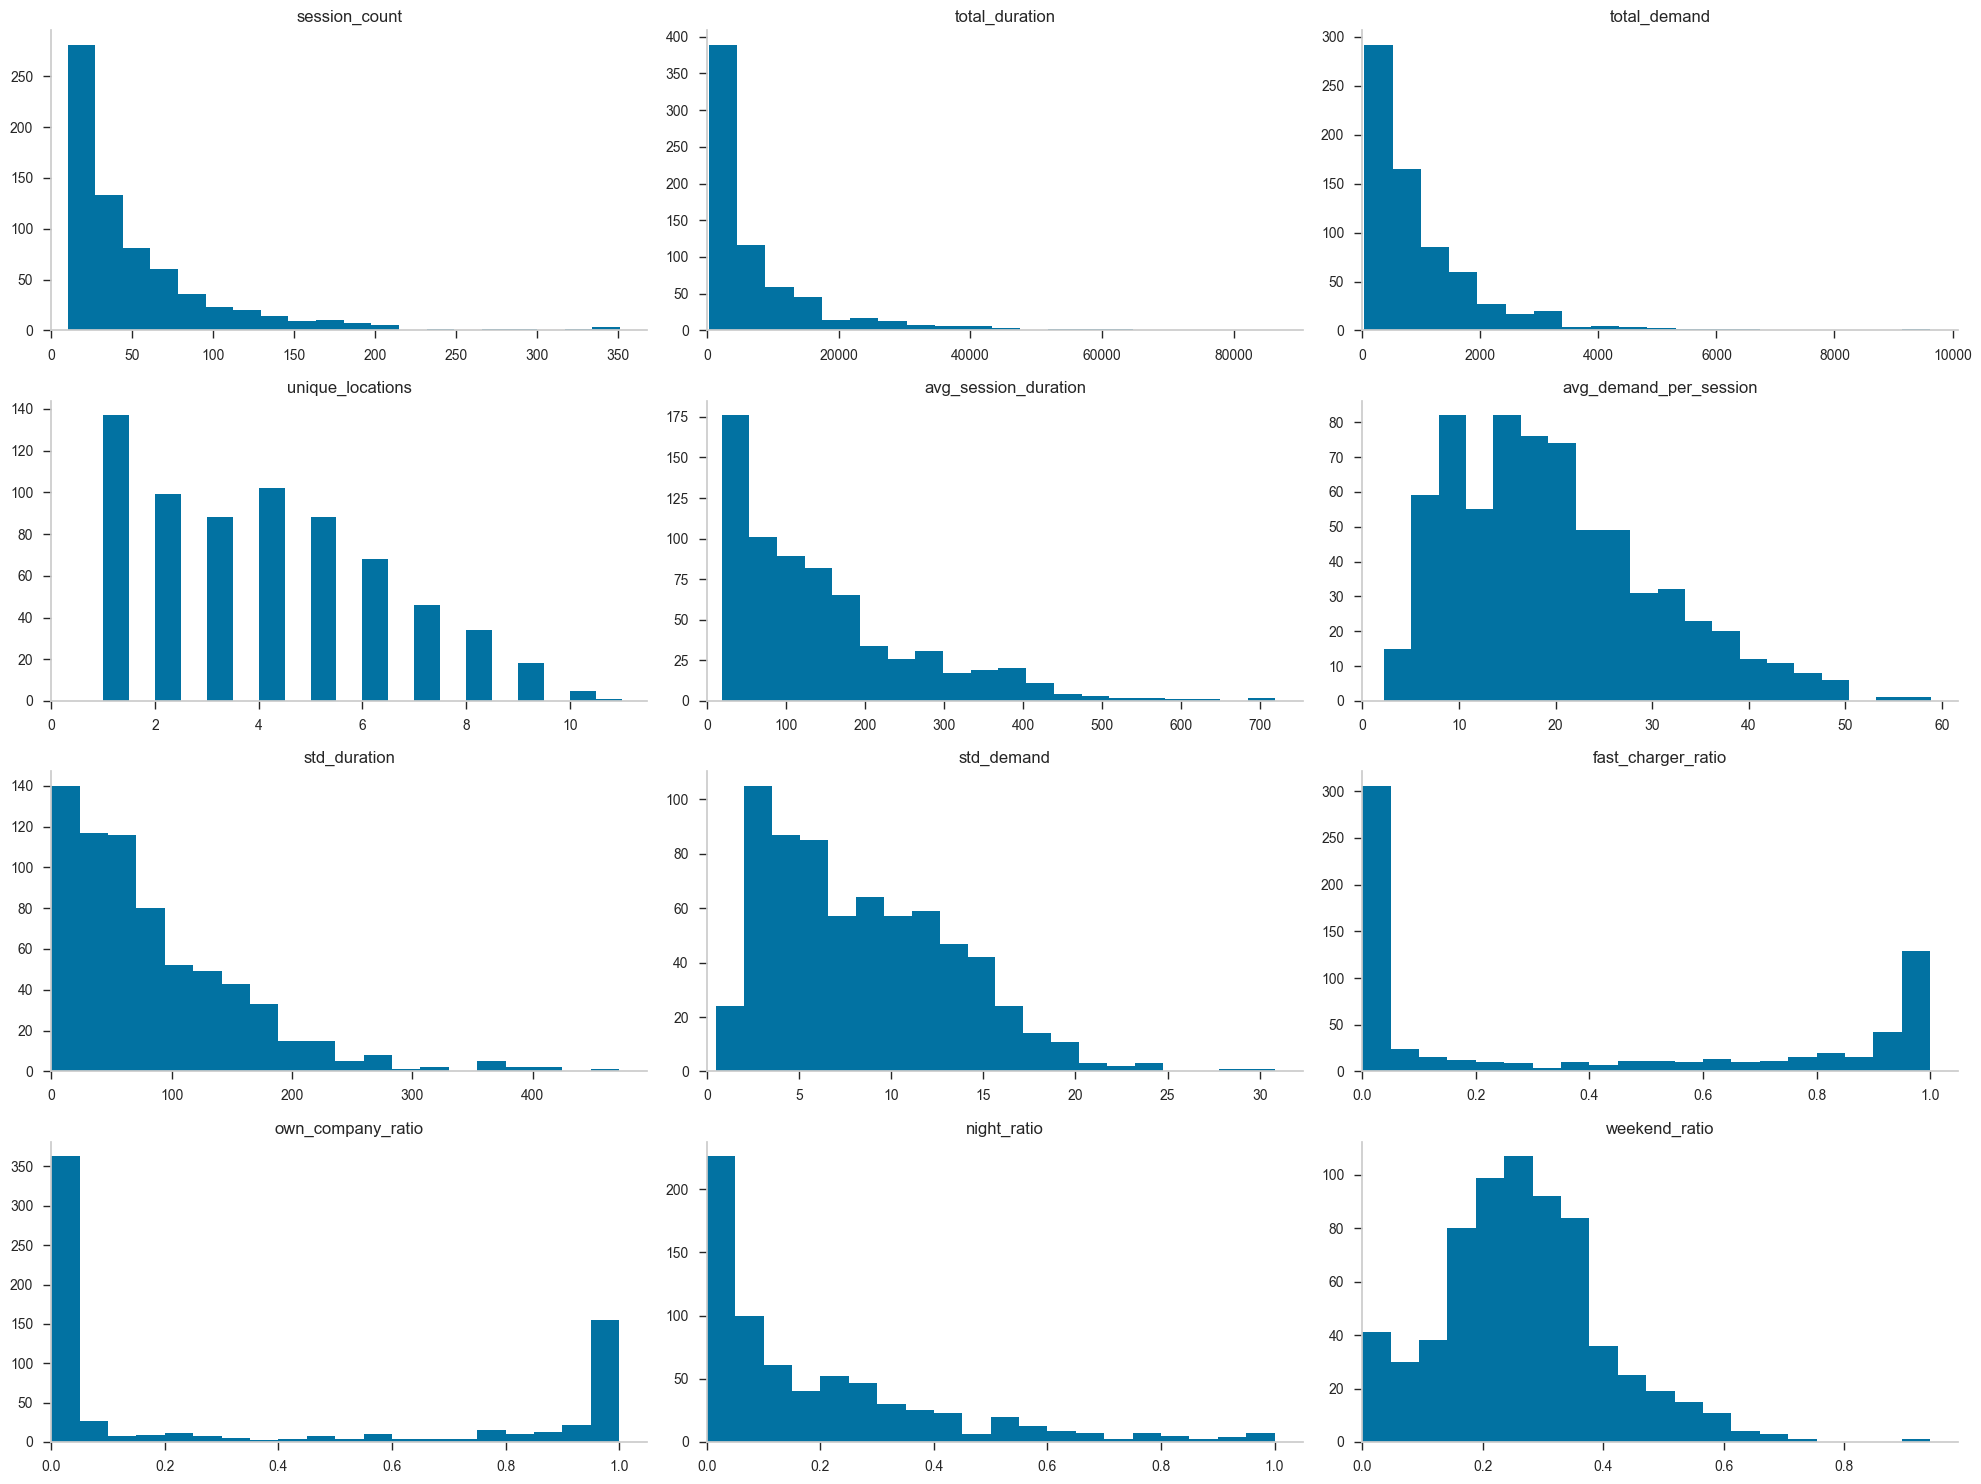

In [25]:
plot_histograms(data_pre_transform_scale)

In [26]:
def plot_boxplots(data):
    plt.figure(figsize=(12, 6))
    
    features_to_plot = data.columns
    n_subplots = len(features_to_plot)
    n_rows, n_cols = (2, 6)
    
    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(y=data[feature])
        plt.grid(False)
        plt.title(feature, fontsize=10, pad=10)
        plt.ylabel('')
        plt.yticks(fontsize=8)
        plt.tick_params(axis='y', which='both', direction='out', length=5)
        
        # Get current y axis limits
        ymin, ymax = plt.ylim()
        # If ymin is greater than 0, extend the axis to include 0
        if ymin > 0:
            plt.ylim(0, ymax)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=1)
    plt.show()


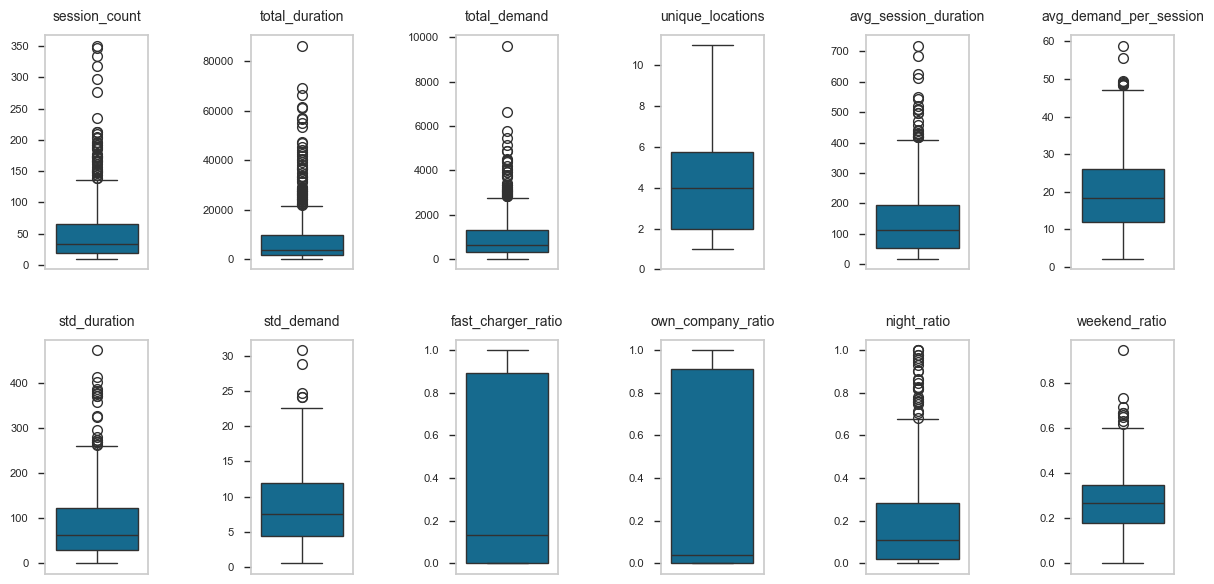

In [27]:
plot_boxplots(data_pre_transform_scale)

In [28]:
data_pre_transform_scale.shape

(686, 12)

We can see
* Significant outliers in most numerical features => I need to handle this
* Strong right-skewed distributions in many features (session_count, total_duration, total_demand, avg_session_duration)
* Different value ranges across features (from 0-1 for ratios to 0-80,000+ for total_duration)
* Bimodal distributions in some ratio features (fast_charger_ratio, own_company_ratio)

## 3.3. Handle outliers

* Outlier handling methods: Use Interquartile Range (IQR), Z-Score and DBSCAN/OPTICS later.
* Target approach: Address outliers upfront for analyses like K-means and HAC, reduce theieimpact on analysis.
* Isolation Forest for non-ratio features: Suitable for skewed or high-dimensional data.
    * Random subsampling: Constructs binary trees with random features and split values.
    * Isolation path: Quickly isolated points (short path) indicate potential outliers.
    * Scoring: Anomaly score reflects isolation ease; short path = outlier, long path = normal.
* Advantages of Isolation Forest:
    * No distribution assumptions; handles skewed histograms.
    * Efficient in high dimensions (suitable for 15+ features).
    * Unsupervised; no need for labeled data.
    * Detects complex outlier patterns beyond IQR or Z-score methods.

In [29]:
iso = IsolationForest(random_state=RANDOM_SEED) #using default parameters

non_ratio_features = ['session_count', 'total_duration', 'total_demand', 
               'avg_session_duration', 'std_duration', 'std_demand', 'avg_demand_per_session', 'unique_locations']


X = data_pre_transform_scale[non_ratio_features]
outliers = iso.fit_predict(X)
data_pre_transform_scale = data_pre_transform_scale[outliers == 1]


In [30]:
data_pre_transform_scale.shape

(579, 12)

107 outliers have been removed.

<Figure size 2000x1500 with 0 Axes>

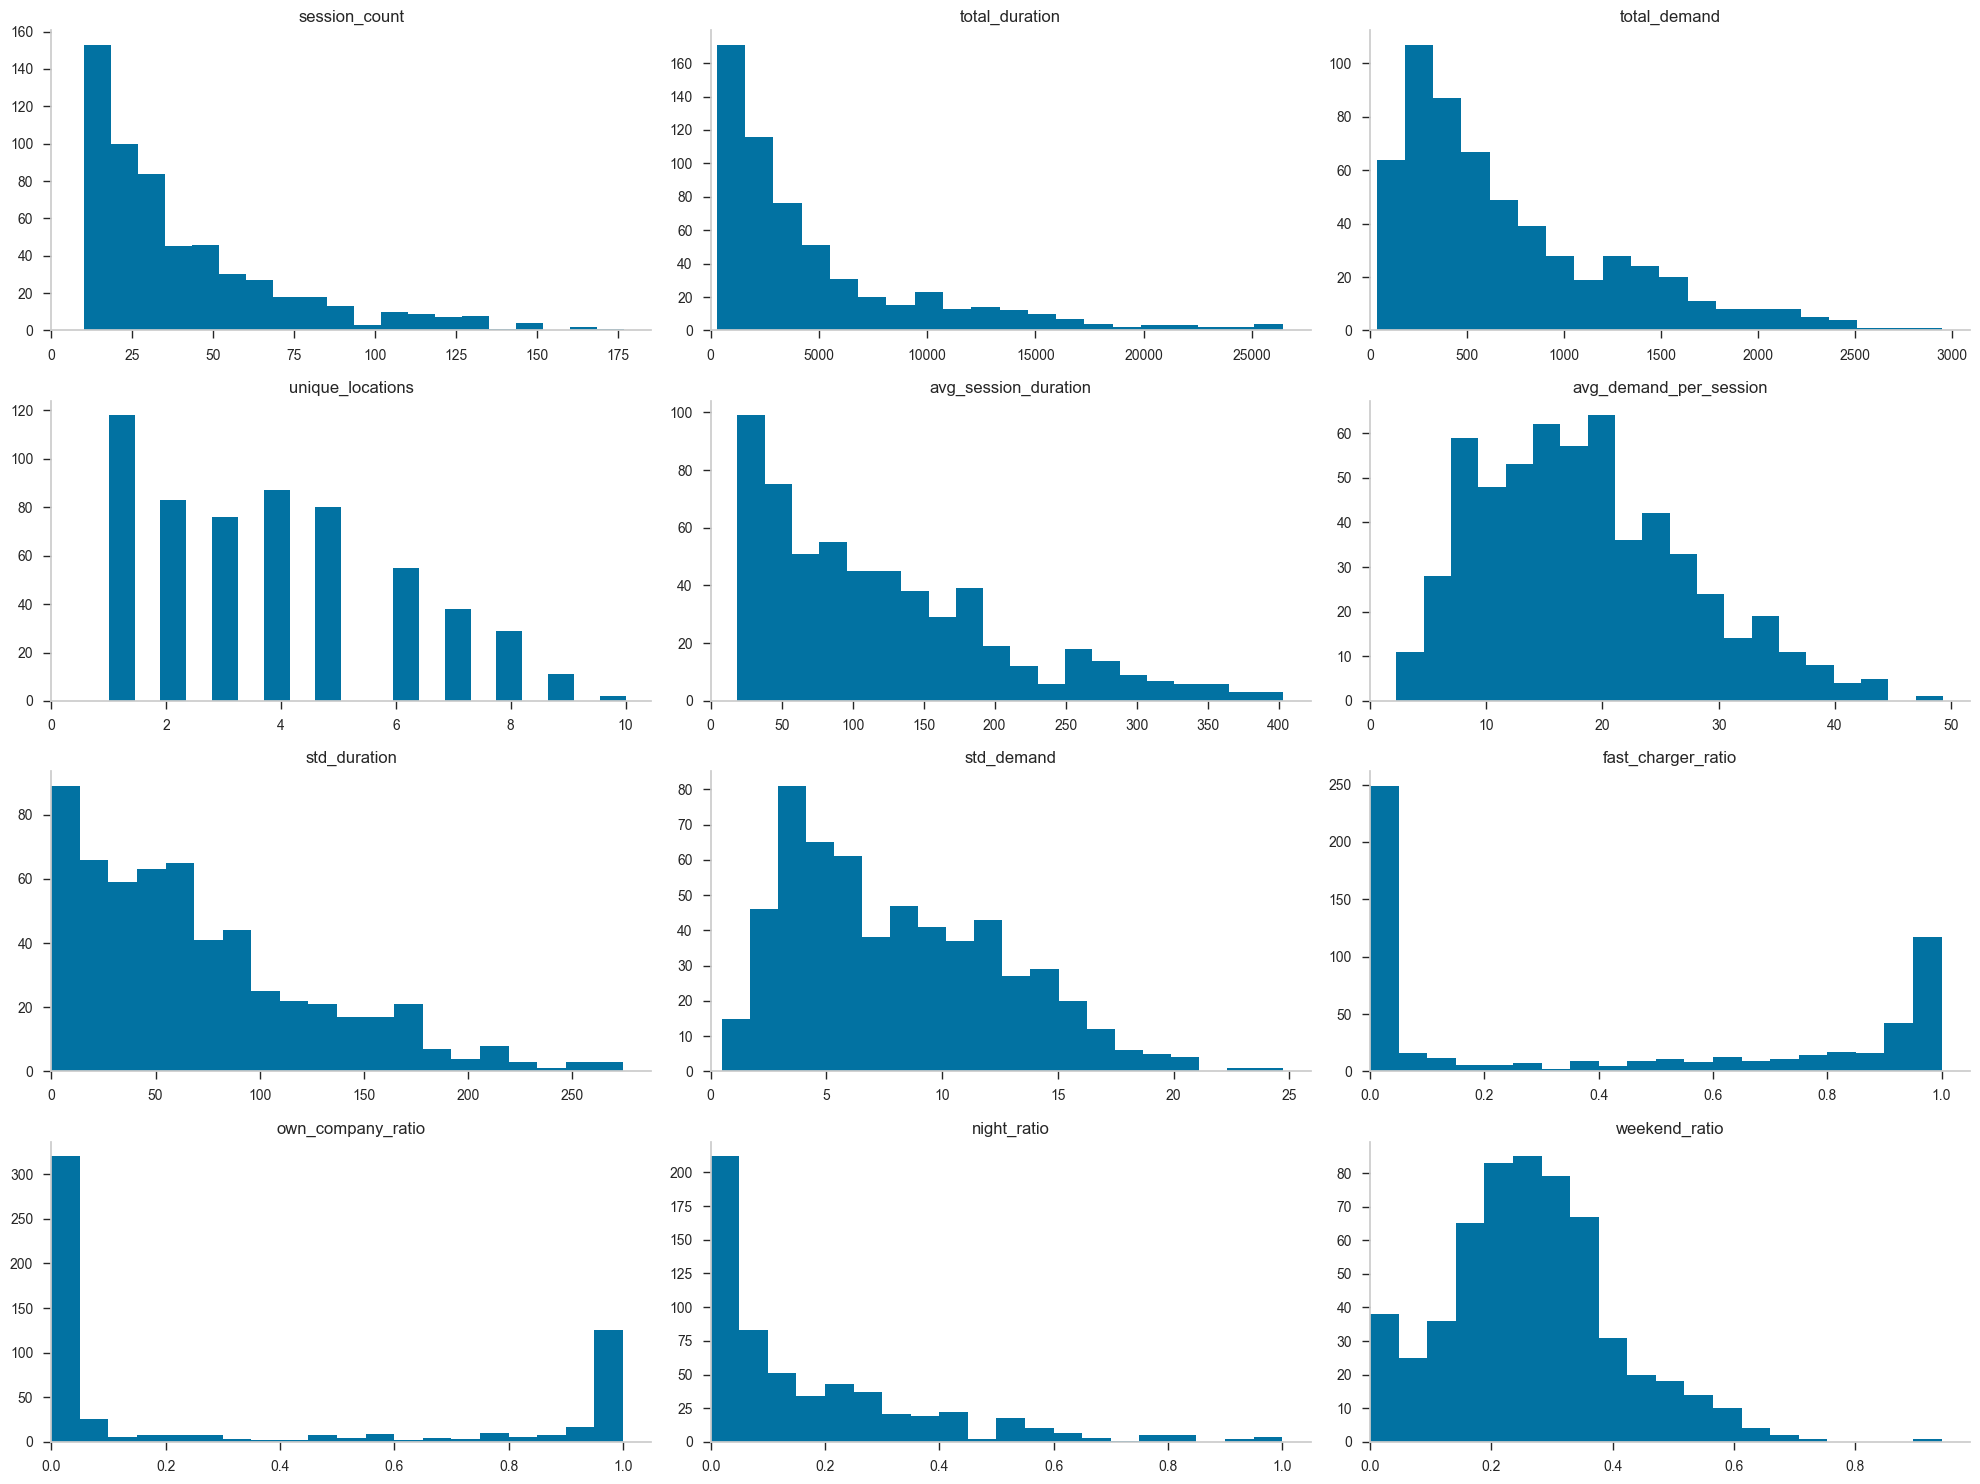

In [31]:
plot_histograms(data_pre_transform_scale)

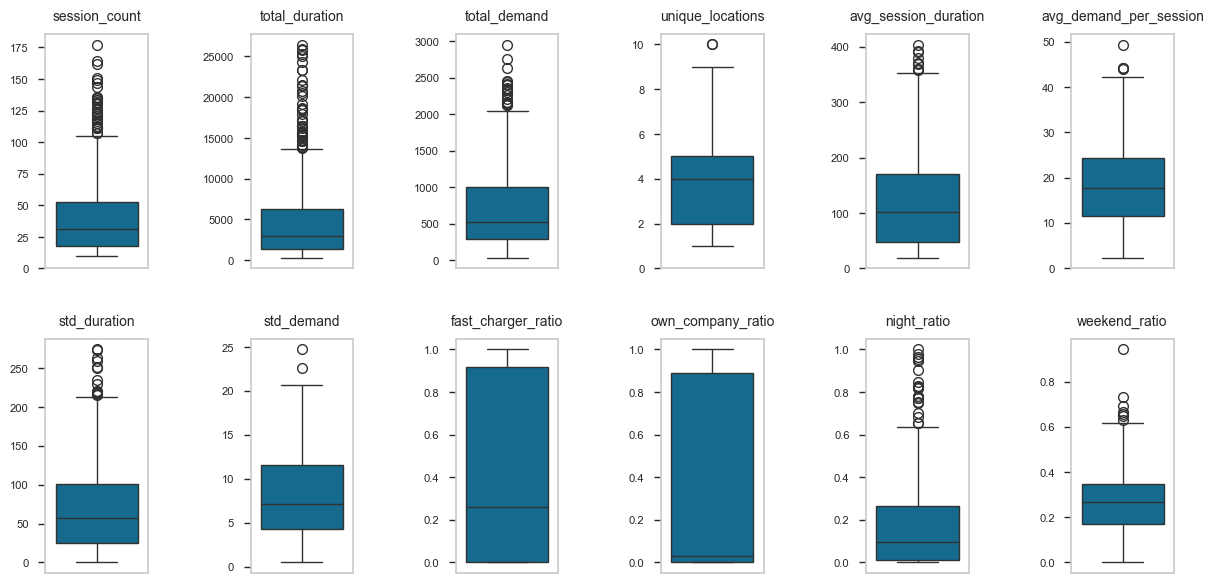

In [32]:
plot_boxplots(data_pre_transform_scale)

## 3.4. Further transform and scale data

* Log transformations: Apply to skewed features to normalize data for better clustering results.
* StandardScaler application: Center and scale features (mean = 0, standard deviation = 1) for consistent range.
* Importance of addressing skewed data:
    * Distance calculation issues: Skewed data affects clustering (K-means, HAC) and DBSCAN's density estimation.
    * Outlier sensitivity: Extreme outliers can misplace cluster centroids, hiding patterns.
    * Algorithm assumptions: Algorithms like K-means and PCA prefer normally distributed data for effective results.
    * Feature dominance: Skewed features can overshadow others, skewing similarity calculations.


In [33]:
data_pre_transform_scale.skew()

session_count             1.551313
total_duration            1.807712
total_demand              1.206379
unique_locations          0.451440
avg_session_duration      1.052337
avg_demand_per_session    0.598778
std_duration              1.077599
std_demand                0.624038
fast_charger_ratio        0.247584
own_company_ratio         0.746438
night_ratio               1.583452
weekend_ratio             0.504619
dtype: float64

Features targeted for transformation

* session_count (Skewness: 1.55): Right-skewed distribution
* total_duration (Skewness: 1.81): Most skewed feature
* total_demand (Skewness: 1.21): Right skewness with a long tail
* avg_session_duration (Skewness: 1.05): Moderately skewed
* std_duration (Skewness: 1.08): Moderate skewness
* night_ratio (Skewness: 1.58): High right skewness

Detailed approach:

* Apply log transformations using log1p for features with zero values: session_count, total_duration, total_demand, avg_session_duration, std_duration, and night_ratio.

* Standardize all features post-transformation for balanced contributions in clustering and PCA.

In [34]:
df = data_pre_transform_scale.copy()
    
# Log transform highly skewed features to reduce impact of outliers on initial centroid selection
log_features = ['session_count', 'total_duration', 'total_demand', 'avg_session_duration', 'std_duration']
for feature in log_features:
    df[feature] = np.log1p(df[feature])
    
df['night_ratio'] = np.sqrt(df['night_ratio'])


In [35]:
df.skew()

session_count             0.269649
total_duration            0.026123
total_demand             -0.353674
unique_locations          0.451440
avg_session_duration     -0.044236
avg_demand_per_session    0.598778
std_duration             -0.513302
std_demand                0.624038
fast_charger_ratio        0.247584
own_company_ratio         0.746438
night_ratio               0.346945
weekend_ratio             0.504619
dtype: float64

<Figure size 2000x1500 with 0 Axes>

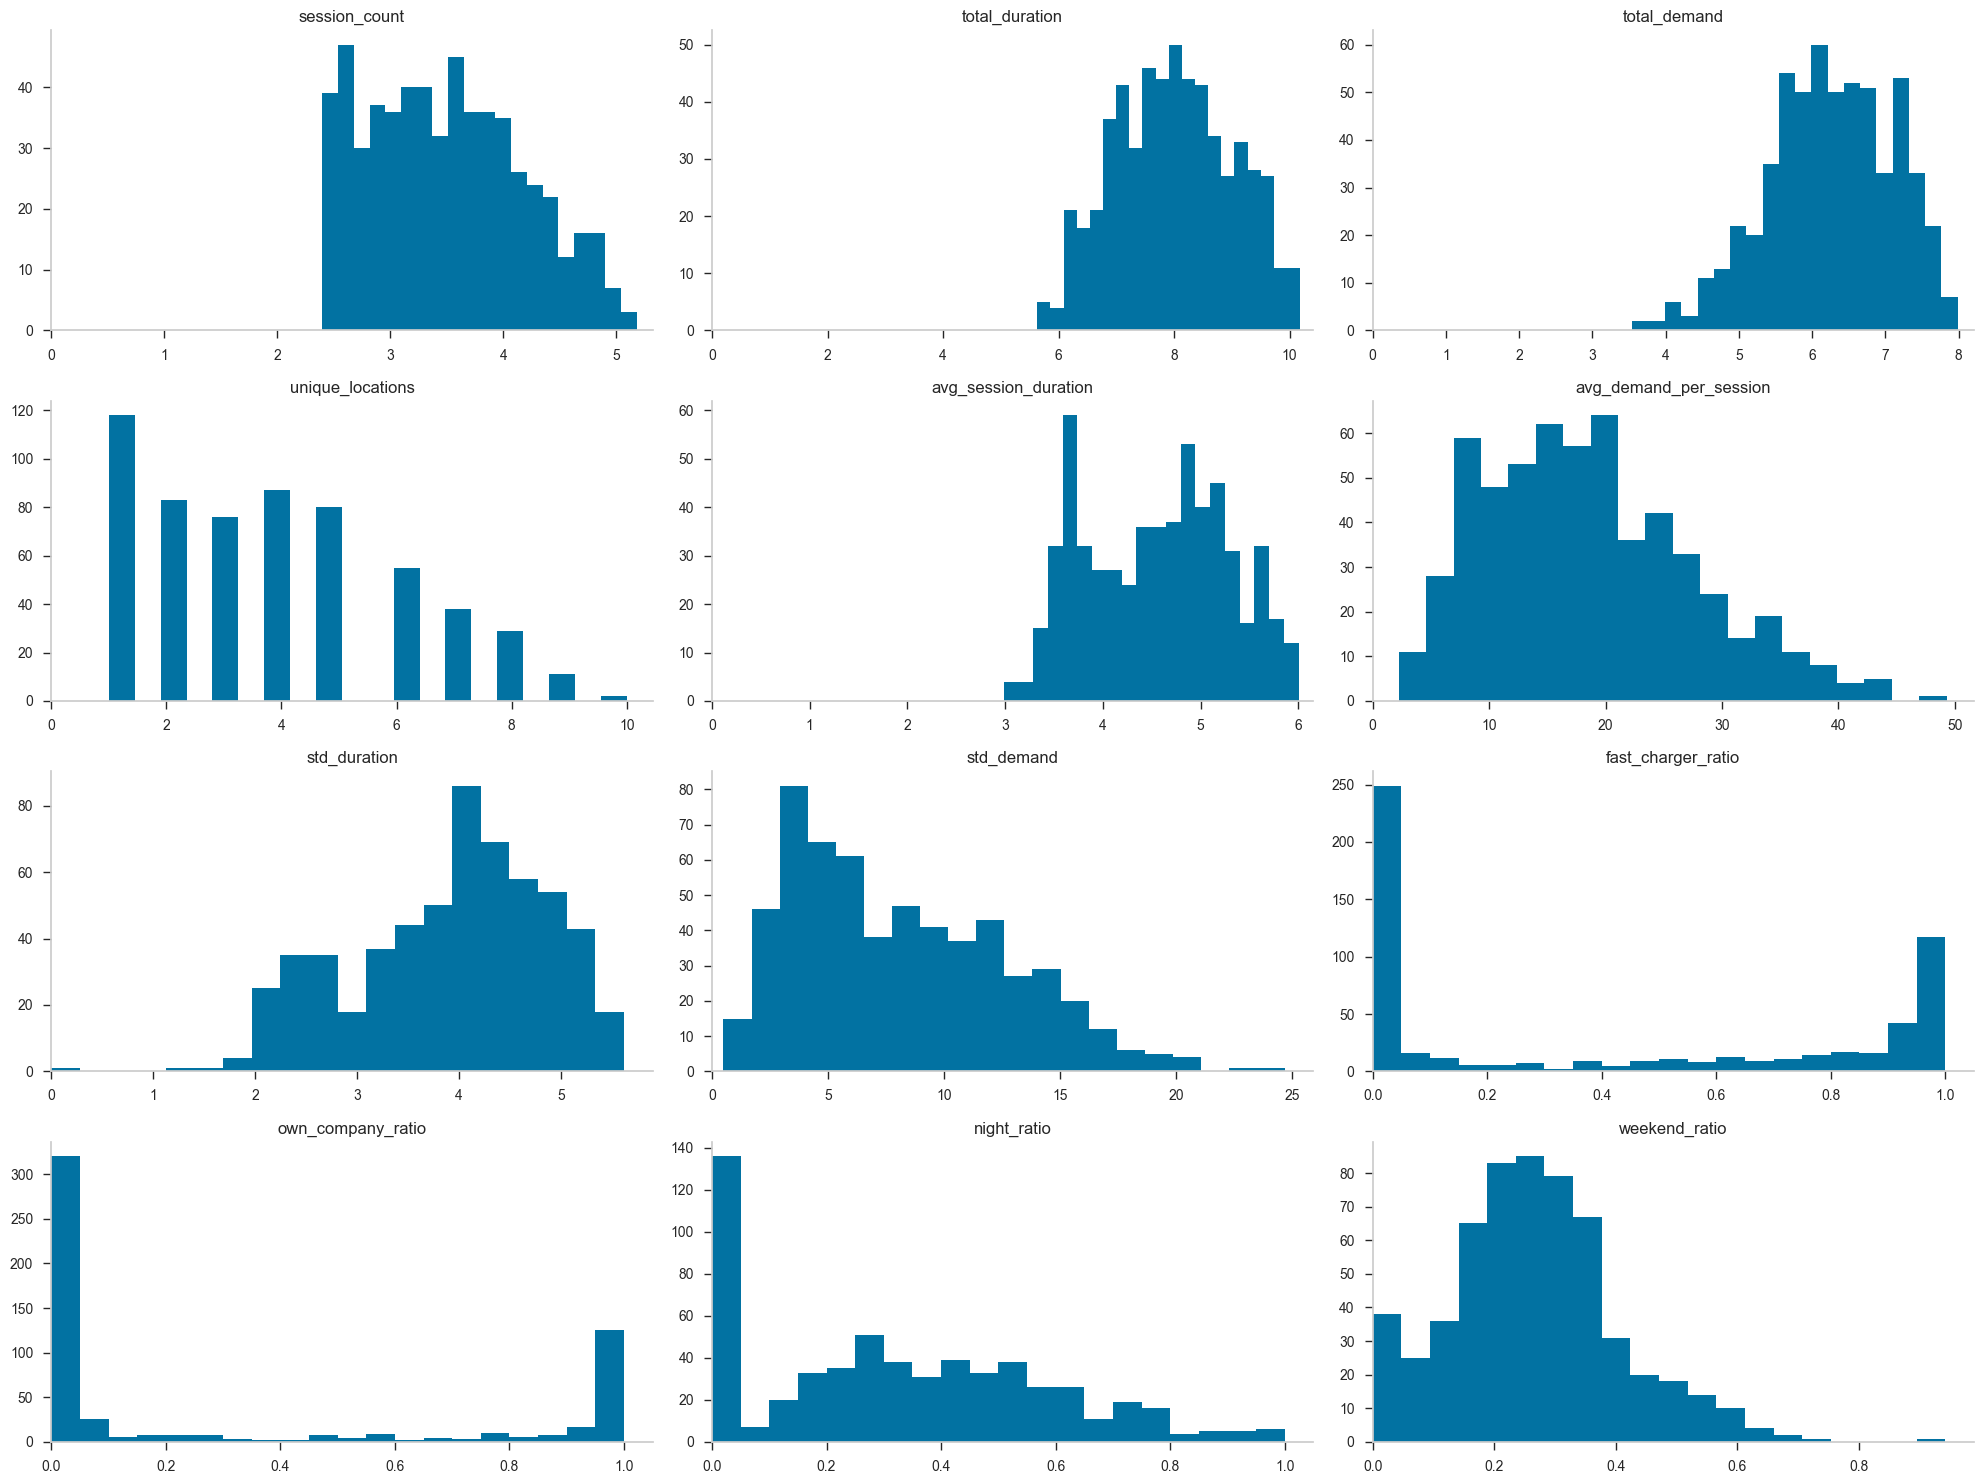

In [36]:
plot_histograms(df)

In [37]:
# Then standardize to equalize feature scales
scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

<Figure size 2000x1500 with 0 Axes>

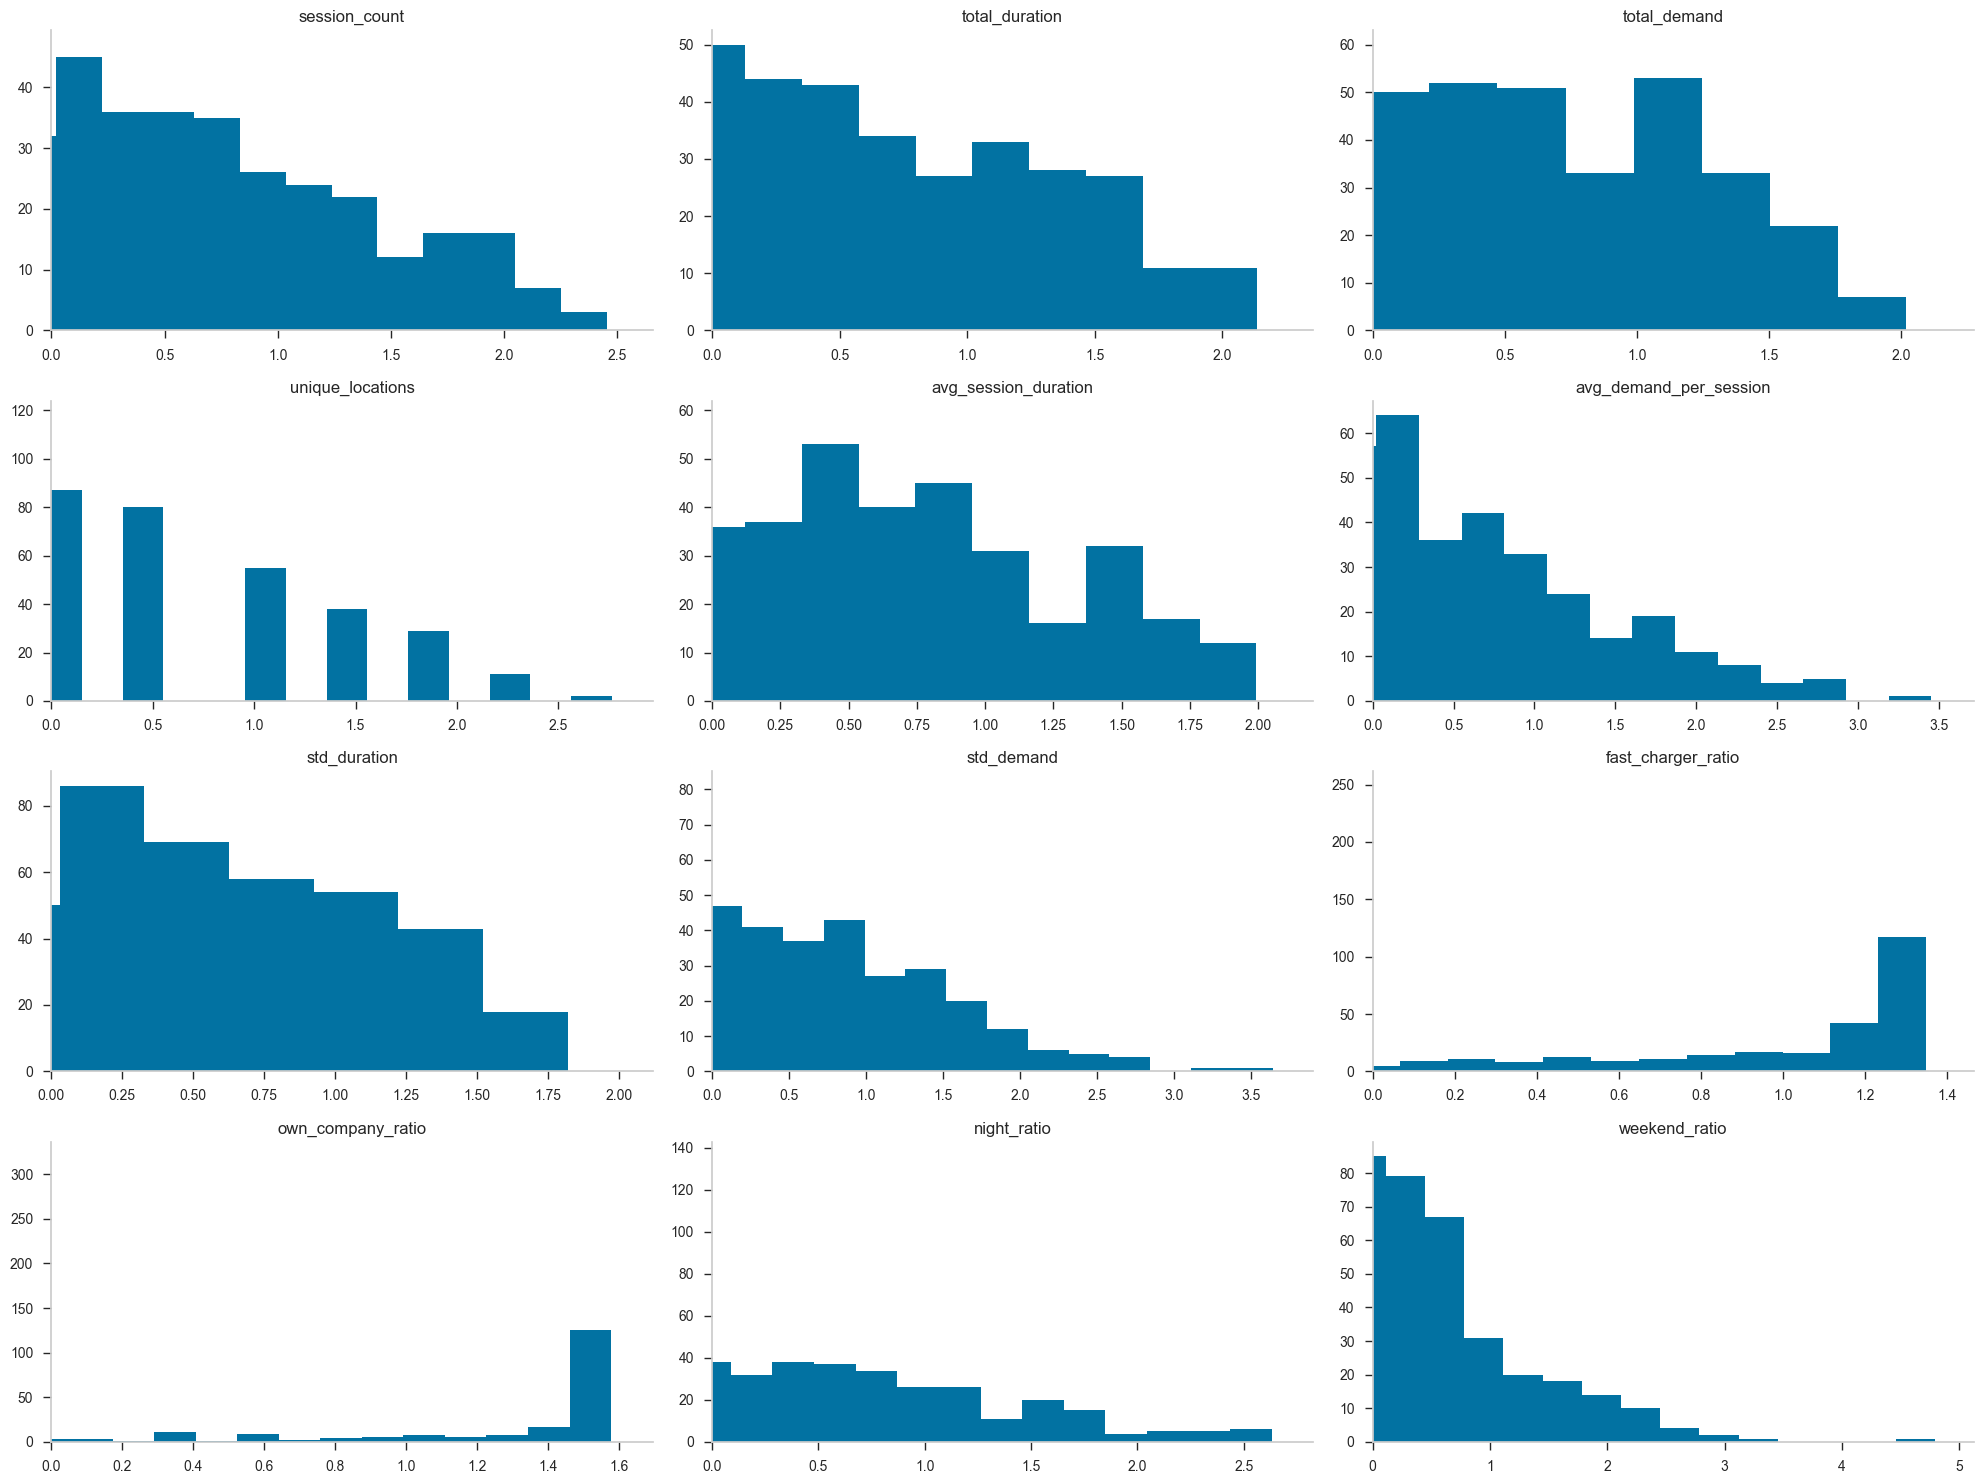

In [38]:
plot_histograms(data)

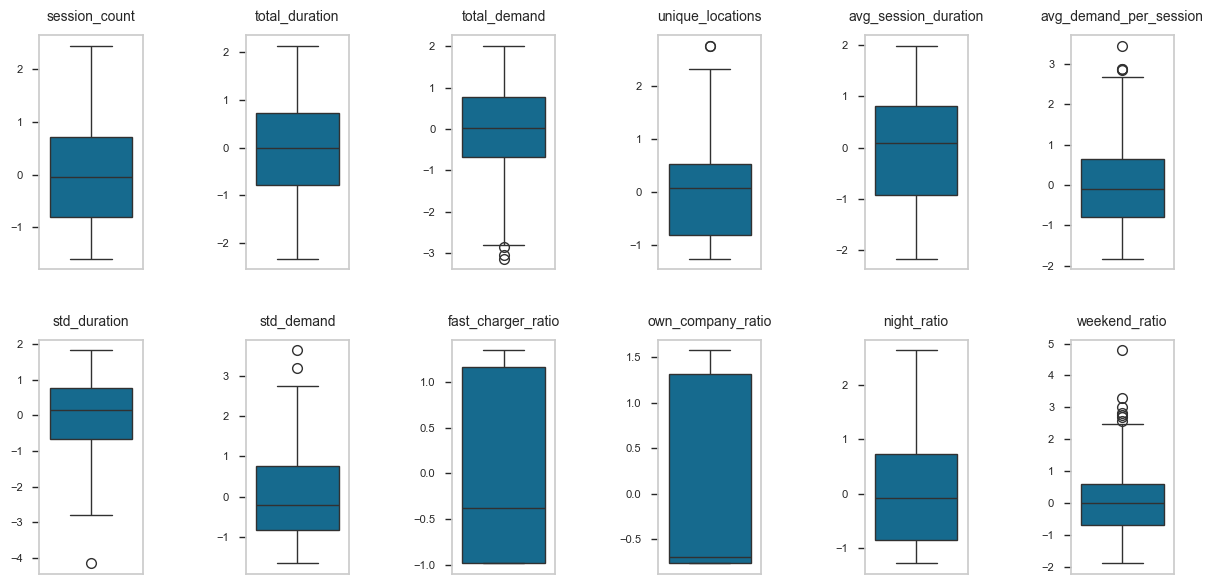

In [39]:
plot_boxplots(data)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   session_count           579 non-null    float64
 1   total_duration          579 non-null    float64
 2   total_demand            579 non-null    float64
 3   unique_locations        579 non-null    float64
 4   avg_session_duration    579 non-null    float64
 5   avg_demand_per_session  579 non-null    float64
 6   std_duration            579 non-null    float64
 7   std_demand              579 non-null    float64
 8   fast_charger_ratio      579 non-null    float64
 9   own_company_ratio       579 non-null    float64
 10  night_ratio             579 non-null    float64
 11  weekend_ratio           579 non-null    float64
dtypes: float64(12)
memory usage: 54.4 KB


In [41]:
data.describe().round(2)

session_count  total_duration  total_demand  unique_locations  \
count         579.00          579.00        579.00            579.00   
mean            0.00            0.00         -0.00              0.00   
std             1.00            1.00          1.00              1.00   
min            -1.60           -2.32         -3.14             -1.26   
25%            -0.80           -0.78         -0.68             -0.81   
50%            -0.04           -0.01          0.02              0.08   
75%             0.72            0.73          0.77              0.53   
max             2.45            2.13          2.02              2.76   

       avg_session_duration  avg_demand_per_session  std_duration  std_demand  \
count                579.00                  579.00        579.00      579.00   
mean                   0.00                    0.00          0.00        0.00   
std                    1.00                    1.00          1.00        1.00   
min                   -2.17                   -1.82         -4.15       -1.66   
25%                   -0.93                   -0.80         -0.68       -0.82   
50%                    0.09                   -0.09          0.16       -0.21   
75%                    0.81                    0.65          0.76        0.75   
max                    1.99                    3.45          1.82        3.64   

       fast_charger_ratio  own_company_ratio  night_ratio  weekend_ratio  
count              579.00             579.00       579.00         579.00  
mean                -0.00              -0.00        -0.00          -0.00  
std                  1.00               1.00         1.00           1.00  
min                 -0.98              -0.76        -1.28          -1.89  
25%                 -0.98              -0.76        -0.86          -0.68  
50%                 -0.38              -0.69        -0.07          -0.01  
75%                  1.16               1.31         0.73           0.58  
max                  1.35               1.58         2.63           4.79

# Task 4 -- Exploratory Data Analysis

<div class="alert alert-block alert-warning"> 
Present 3 highlights from the exploratory data analysis in your draft.

(Commented code + bullet points, add cells below under the respective hightlight headlines)

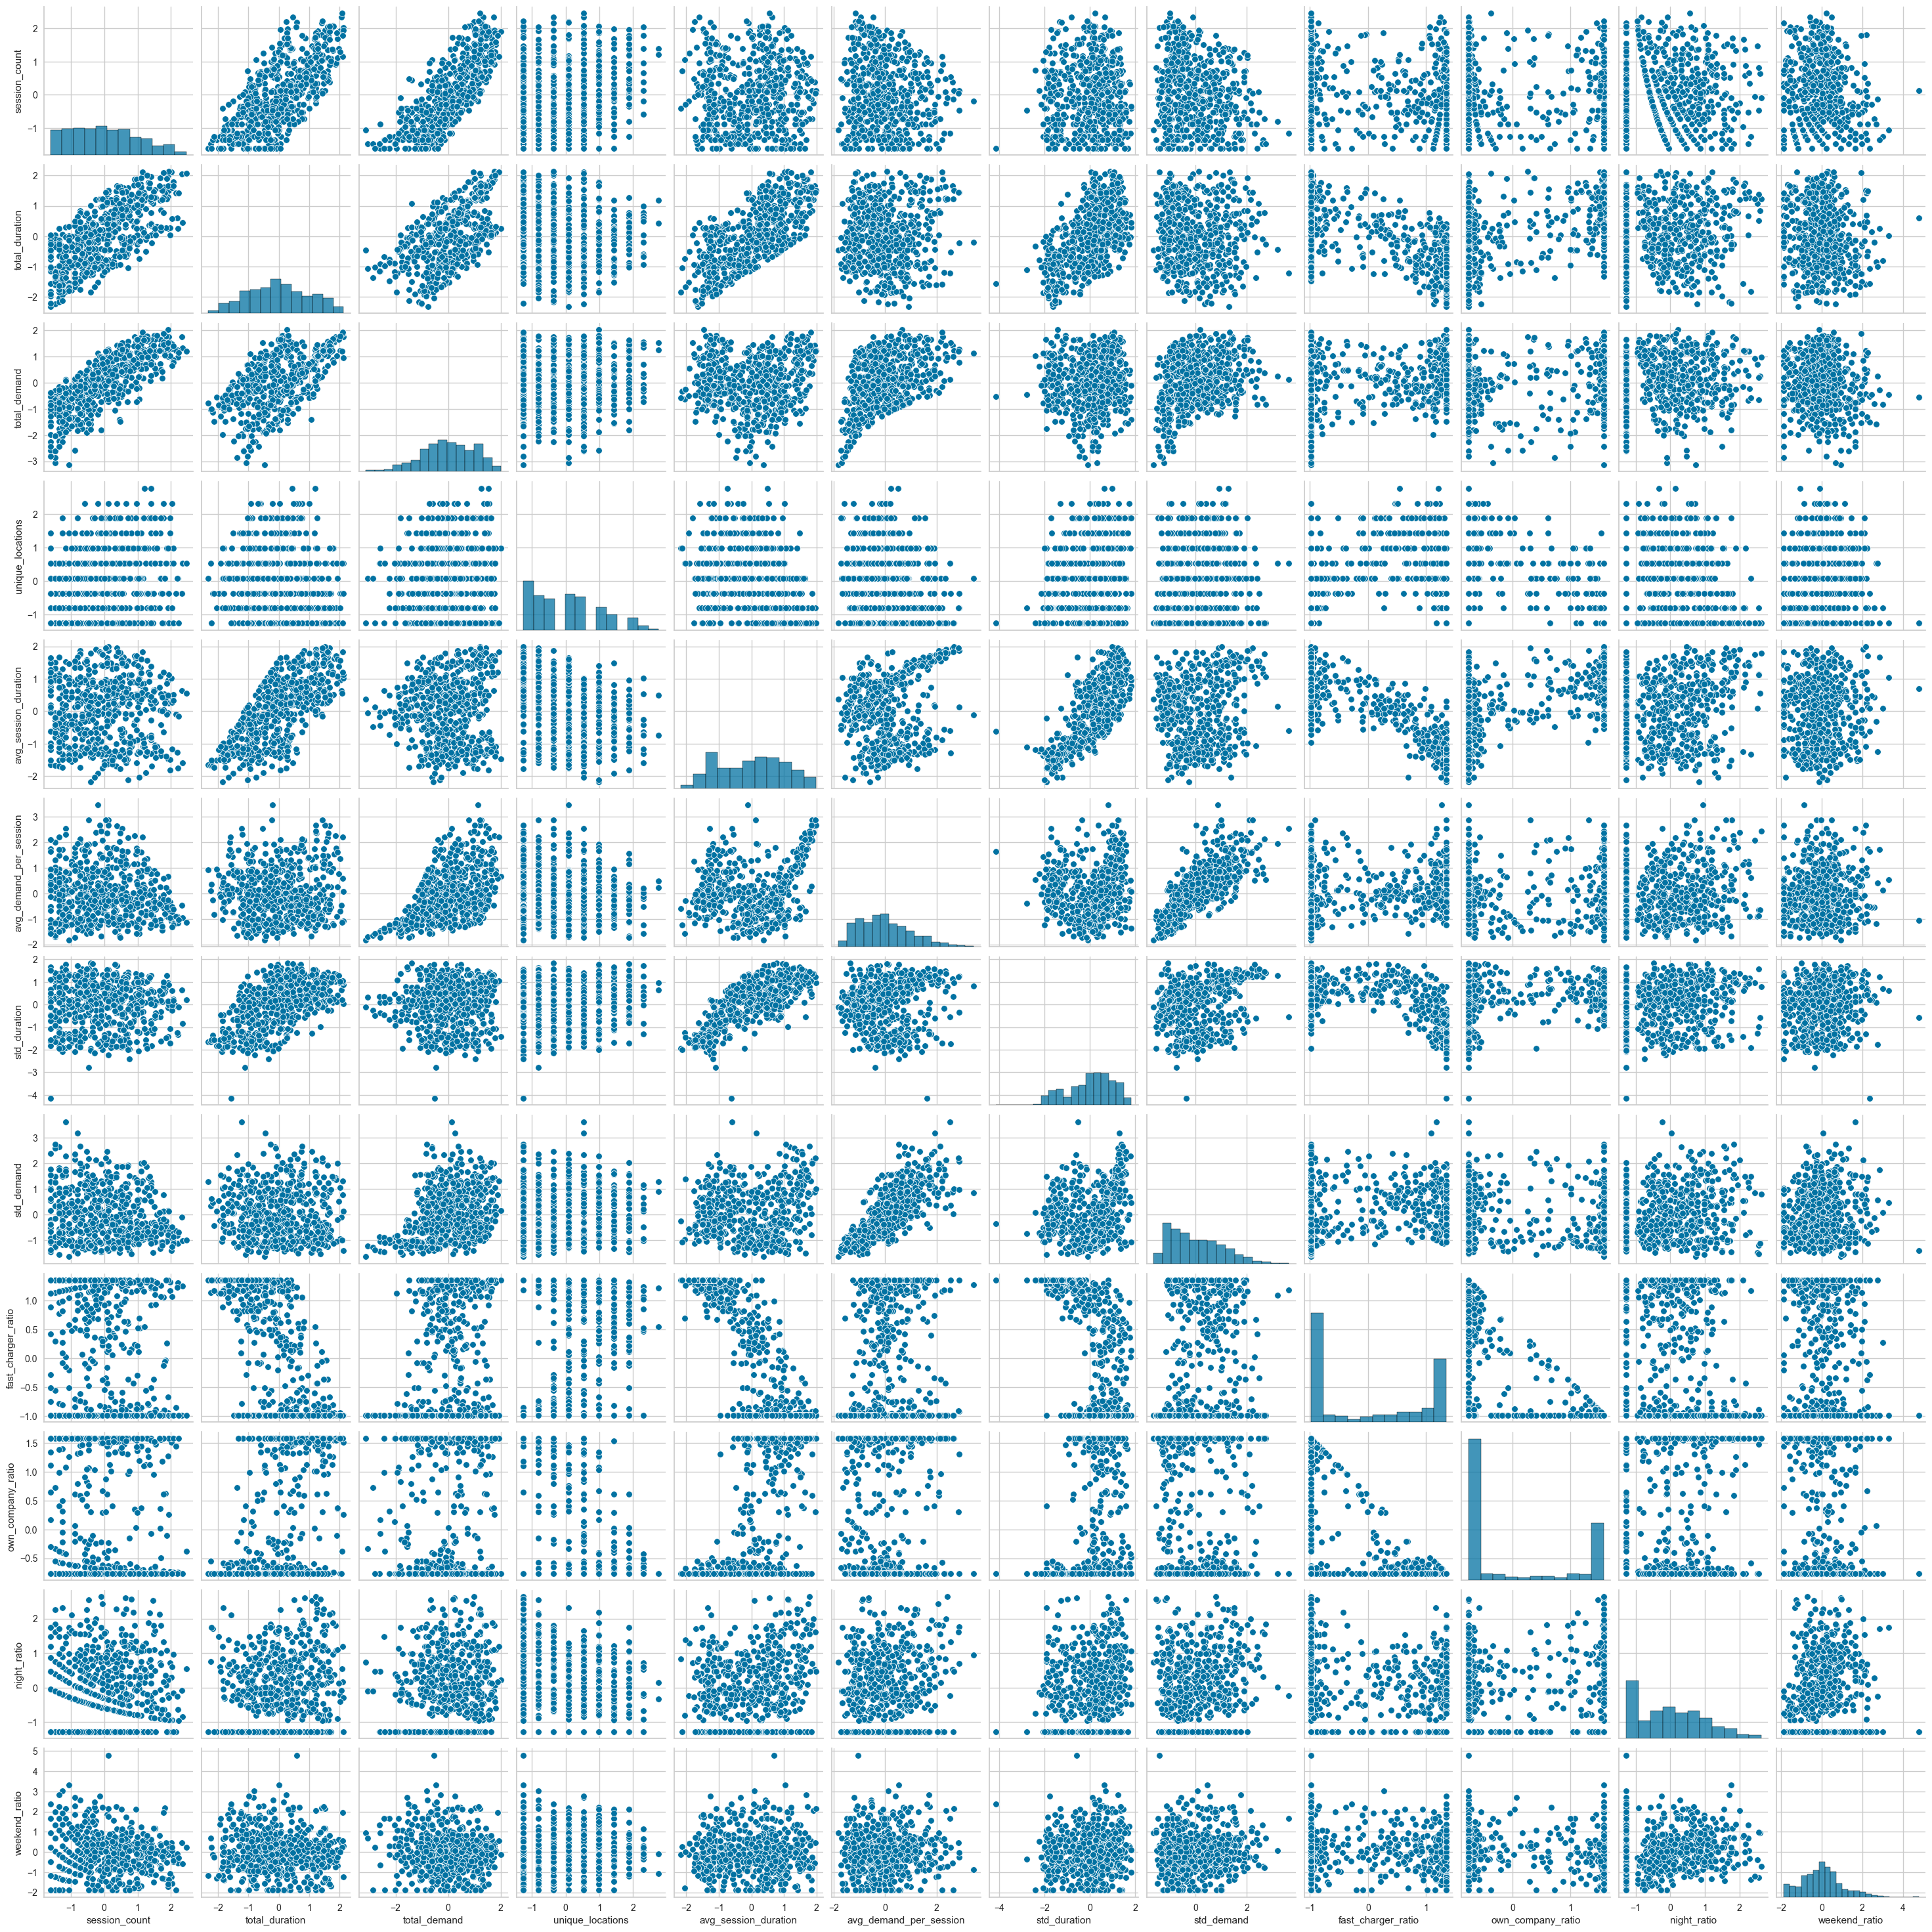

In [42]:
sns.pairplot(data)

## EDA Highlight 1

* Strong positive linear relationships: Several pairs show clear positive correlations, visible as diagonal lines trending from bottom-left to top-right. These indicate that as one variable increases, the other tends to increase proportionally.

    * session_count - total_duration
    * session count - total_demand
    * total_demand - total_duration
    * total_duration - average_session_duration
    * avg_demand_per_session - std_demand
    * avg_session_duration - std_duration

## EDA Highlight 2

*  No correlation/random scatter: Many pairs exhibit random scatter patterns with no obvious structure, suggesting little to no relationship between those variables.
    * session_count - avg_session_duration
    * session_count - avg_demand_per_session
    * total_duration - weekend_ratio 
    etc.

## EDA Highlight 3

* Discrete/Categorical variables: Several columns/rows show vertical or horizontal stripe patterns, indicating discrete or categorical variables being plotted against continuous variables.
    * session_count - night_ratio
    * session_count - weekend_ratio
    etc.

# Task 5 -- Dimensionality Reduction

<div class="alert alert-block alert-warning"> 
<b>PCA</b>: 
Conduct your analyses and transformations according to Task 5.
Call the transformed dataset "data_pca".

(Commented code + bullet points, add cells below)
</div>

Based on the characteristics observed in scatterplot matrix, PCA is particularly suitable for your dataset for several reasons:

* High dimensionality

* Visible correlations

* Mixed relationship patterns

* Potential redundancy

In [43]:
model = pca(n_components=0.75, random_state=RANDOM_SEED)
pca_result = model.fit_transform(data)['PC']

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [75.0%] explained variance using the [12] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [4] that covers the [75.00%] explained variance.
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [44]:
data_pca = pca_result
data_pca

PC1       PC2       PC3       PC4
0    2.419910  0.030775 -0.373501 -0.954831
1    1.209576  0.954617 -0.168977  0.788027
2    3.018613  2.881205 -0.873432 -0.410234
3    2.108890  0.779359  1.233728  0.425109
4    2.316634  0.466491  2.339709  0.877727
..        ...       ...       ...       ...
574  1.864859 -1.836779  0.718836 -0.166272
575 -2.440482 -0.821339 -1.473953  0.897159
576  0.526172 -3.756320 -1.692819  0.465246
577  1.723220 -0.746462 -0.645745 -1.333811
578 -0.896687 -3.816410 -1.029015  0.275360

[579 rows x 4 columns]

* PCA application: Achieved significant dimensionality reduction while maintaining data integrity.
* Variance capture: 4 principal components account for approximately 80% of the original data's variance.
* Dimension reduction: Reduced from 12 original dimensions to just 4, simplifying analysis.

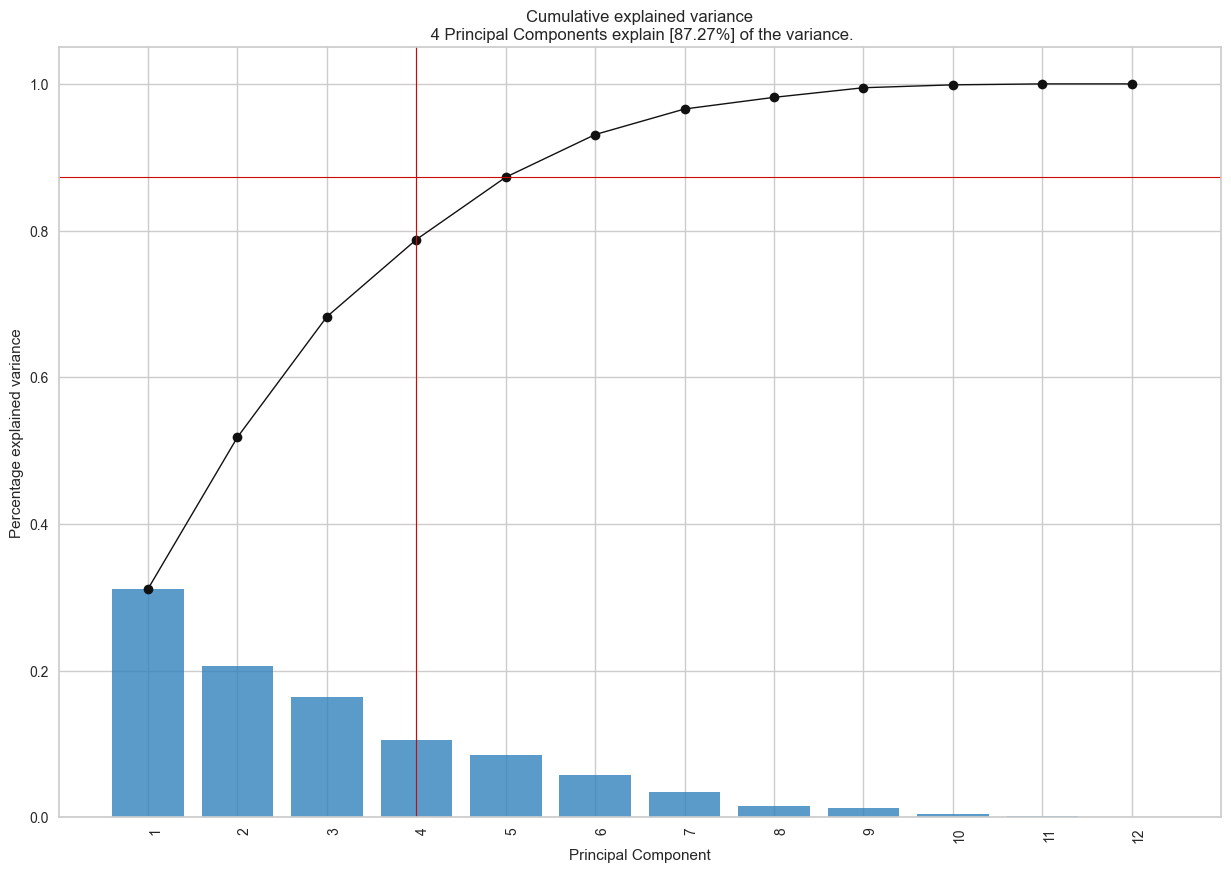

In [45]:
# explained variance
fig, ax = model.plot()

[18-05-2025 23:03:41] [scatterd.scatterd] [INFO] Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(None,
 <Axes: title={'center': '4 Principal Components explain [87.27%] of the variance'}, xlabel='PC1 (31.1% expl.var)', ylabel='PC2 (20.6% expl.var)'>)

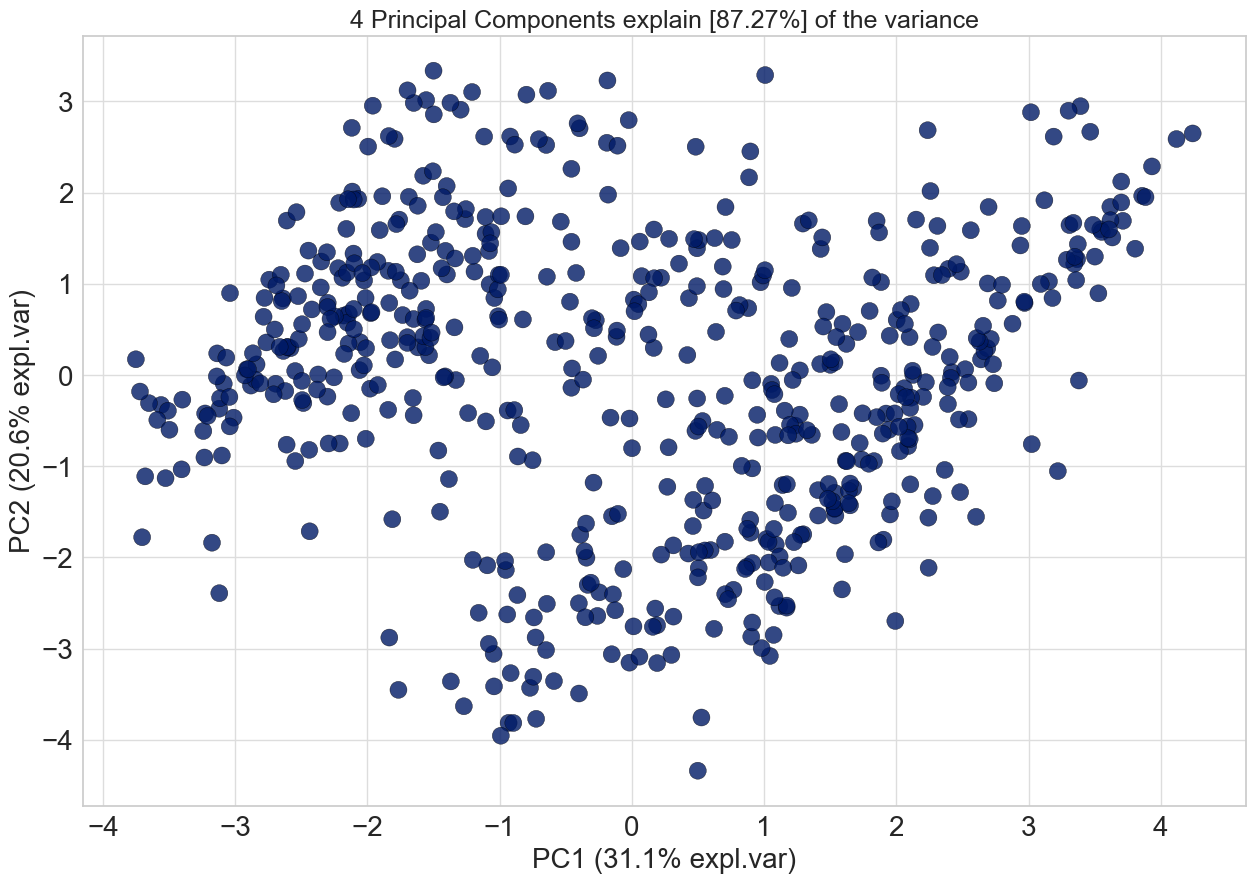

In [46]:
fig, ax = plt.subplots(figsize=(15, 10)) 

model.scatter(ax=ax, legend=False)

In [47]:
model.results['loadings'].round(3)

session_count  total_duration  total_demand  unique_locations  \
PC1          0.158           0.452         0.146            -0.206   
PC2          0.289           0.153         0.540             0.169   
PC3          0.577           0.273         0.273             0.143   
PC4          0.065           0.104        -0.126             0.591   

     avg_session_duration  avg_demand_per_session  std_duration  std_demand  \
PC1                 0.477                   0.054         0.377       0.021   
PC2                -0.067                   0.467         0.034       0.445   
PC3                -0.177                  -0.367        -0.184      -0.424   
PC4                 0.081                  -0.301         0.356      -0.037   

     fast_charger_ratio  own_company_ratio  night_ratio  weekend_ratio  
PC1              -0.426              0.366        0.137         -0.029  
PC2               0.312             -0.170        0.158          0.017  
PC3               0.003             -0.060       -0.200         -0.273  
PC4              -0.051             -0.311        0.243          0.486

In [48]:
model.results['explained_var']

array([0.31152408, 0.51832926, 0.68259384, 0.78769936, 0.87277839,
       0.93091722, 0.96577831, 0.98165165, 0.99476588, 0.99870579,
       0.9999973 , 1.        ])

# Task 6 -- Clustering

<div class="alert alert-block alert-warning"> 
<b>Choice of Algorithm</b>: 
Given the situation in the pitch and the results from the above analyses. Which algorithm (chosen from those discussed in the lectures) would YOU choose for the clustering? Explain!
    
(Choice + 1-3 bullet points in the cell below)
</div>

My Choice: OPTICS

* **No predefined number of clusters**: The K-means experiments tested multiple values of K (3, 4, and 6) without clear consensus on the optimal number. OPTICS doesn't require specifying the number of clusters beforehand, instead discovering them naturally based on density patterns.

* **Noise handling**: Your dataset likely contains outliers or noise points that don't belong to any natural cluster, as evidenced by the scattered distribution in the PCA visualization. OPTICS can explicitly identify these as noise points rather than forcing them into clusters.

* **Variable density clusters**: The boxplots from the K-means analysis suggest considerable overlap between clusters across multiple features. OPTICS can identify clusters of varying densities and shapes, making it ideal for datasets where clusters may have different characteristics.

<div class="alert alert-block alert-danger"> 
<b>Requirements</b>: 
In the following and for the remainder of the final phase of the exam (indenpendent of what your choice above suggests), use 

* a clustering algorithm $A$ chosen from the family: __k-means/k-means++__
* the evaluation metric $E_1$: __Silhouette Score__
* the evaluation metric $E_2$: __Davies-Bouldin Index__.
</div>

## Comprehensive clustering analysis
<div class="alert alert-block alert-warning"> 
<b>Clustering</b>: 
On both datasets, data and data_pca, under their respective headlines below, conduct comprehensive clustering analyses with algorithm $A$, using the available methodology from the module and specifically $E_1$ and $E_2$. Conduct ALL necessary steps to create the most helpful and meaningful clustering per dataset and discuss its quality. Use appropriate diagrams to demonstrate the results. 

(Commented code + bullet points, add cells)
</div>

* I chose Euclidean distance for clustering because PCA transformation creates orthogonal components suitable for Euclidean space. 
* This distance also aligns with K-Means by minimizing within-cluster variance under spherical cluster assumptions.

### Clustering Analysis of plain data

#### Setup

In [49]:
def plot_kmeans_metrics(data, n_init, max_iter, tol):
    silhouette_scores = []
    davies_bouldin_scores = []

    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=n_init, init='k-means++', max_iter=max_iter, tol=tol)
        cluster_labels = kmeans.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        davies_bouldin_avg = davies_bouldin_score(data, cluster_labels)
        davies_bouldin_scores.append(davies_bouldin_avg)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for ax in axs:
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axs[0].plot(range(2, 11), silhouette_scores, marker='o')
    axs[0].set_title('Silhouette Scores for KMeans Clustering', fontsize=14)
    axs[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axs[0].set_xticks(range(2, 11))


    axs[1].plot(range(2, 11), davies_bouldin_scores, marker='o')
    axs[1].set_title('Davies-Bouldin Score for KMeans Clustering', fontsize=14)
    axs[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axs[1].set_xticks(range(2, 11))

    plt.tight_layout()
    plt.show()

In [50]:
def perform_kmeans_clustering(data, k, n_init, max_iter, tol):

    kmeans_pp = KMeans(
        n_clusters=k,
        random_state=RANDOM_SEED,
        n_init=n_init,
        init='k-means++',
        max_iter=max_iter,
        tol=tol
    )

    cluster_labels = kmeans_pp.fit_predict(data)
    
    result_kmeans = data_pre_transform_scale.copy()
    result_kmeans['Cluster'] = cluster_labels
  
    print(result_kmeans['Cluster'].value_counts())

    visualizer = SilhouetteVisualizer(kmeans_pp, colors='yellowbrick')
    visualizer.fit(data)
    visualizer.show()

    features_to_plot = [col for col in result_kmeans.columns if col != 'Cluster']
    
    n_cols = 4
    n_rows = 3

    plt.figure(figsize=(15, n_rows * 4))

    for i, feature in enumerate(features_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x='Cluster', y=feature, data=result_kmeans)
        plt.grid(False)
        plt.title(feature, fontsize=10, pad=10)
        plt.xlabel('Cluster', fontsize=9)
        plt.ylabel('')
        plt.yticks(fontsize=8)
        plt.tick_params(axis='y', which='both', direction='out', length=6)

    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    plt.show()

    return result_kmeans

#### Find optimal k

* The hyperparameter tuning in the draft shows minimal score variation when adjusting n_init, max_iter, and tol. 
* Therefore, we can confidently select the same parameter combination as outlined in the draft version.

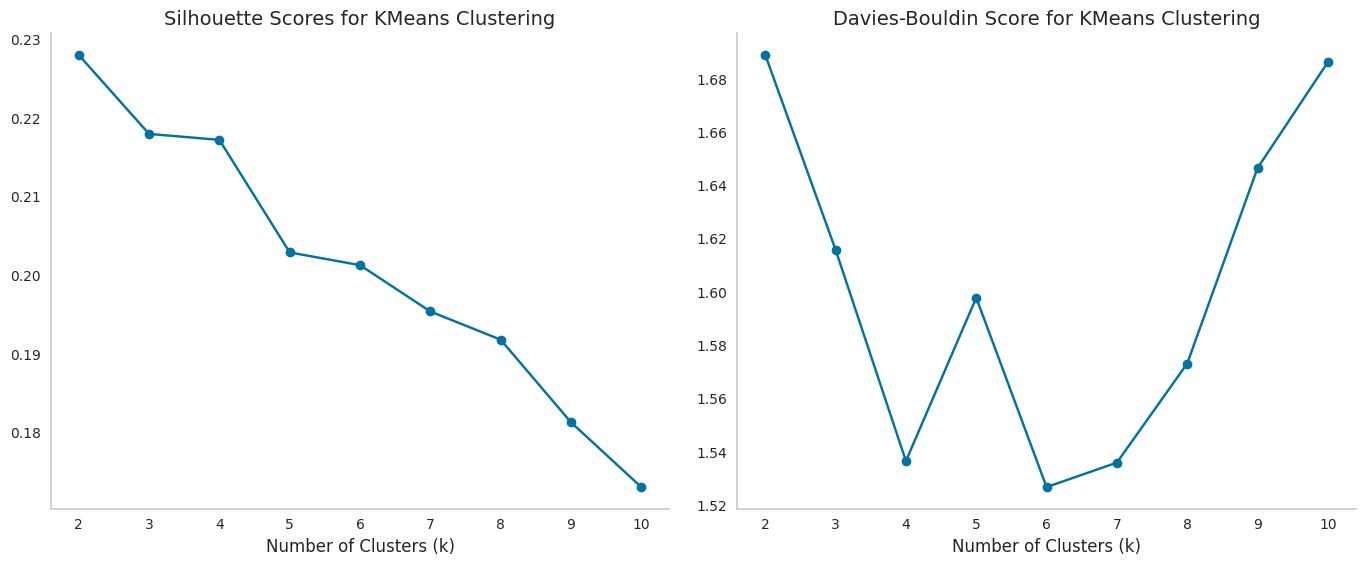

In [51]:
plot_kmeans_metrics(data, n_init=10, max_iter=100, tol=0.0001)

* We can see that silhouette score is very low, and the Davies-Bouldin score is pretty high, indicating that the clusters have a very weak to no structures for all k.

* We can choose k = 3 and 4 to inspect the structure of the clusters.

Rule of thumb for Silhouette score:

* s<sub>C</sub> >0.7: strong structure
* 0.7 ≥ s<sub>C</sub> >0.5: usable structure
* 0.5 ≥ s<sub>C</sub> >0.25: weak structure
* 0.25 ≥ s<sub>C</sub>: no structure

#### Result 1 - data

Cluster
1    242
0    189
2    148
Name: count, dtype: int64


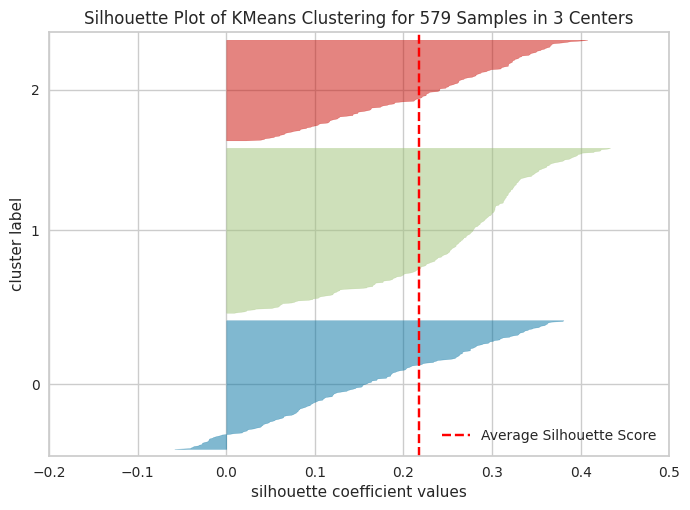

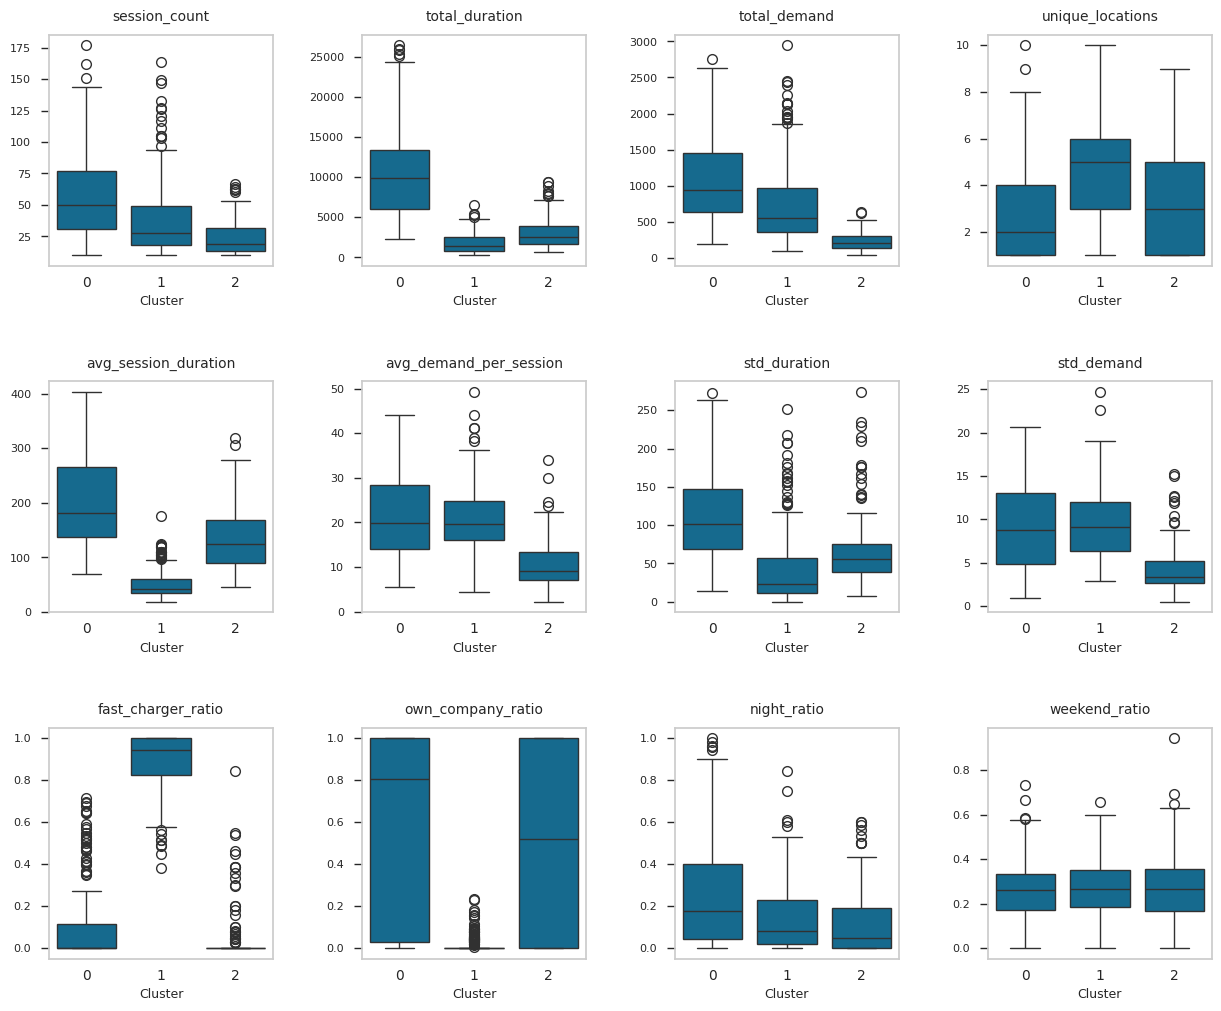

In [52]:
kmeans_data_cluster_results_1 = perform_kmeans_clustering(data, k=3, n_init=10, max_iter=100, tol=0.0001)

Silhouette plot analysis summary

* Average score: ~0.22, indicating very weak clustering structure

* All clusters: Show mostly positive coefficients (0 to 0.45), suggesting generally appropriate assignments

* Cluster sizes: Vary with cluster 2 (green) appearing largest

* Boundary samples: A lot of samples in each cluster have scores near 0, indicating they sit at cluster boundaries

* No misassignments: Few negative values in cluster 0 suggests minimal incorrect cluster assignments

* Overall quality: Acceptable but weak

In [53]:
kmeans_data_cluster_results_1

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        0  
3             0.235294        0  
6             0.226415        0  
7             0.275362        0  
8             0.270492        0  
...                ...      ...  
2356          0.205128        2  
2388          0.500000        1  
2393          0.500000        2  
2421          0.105263        0  
2464          0.300000        2  

[579 rows x 13 columns]

#### Result 2 - data

Cluster
1    221
3    126
2    118
0    114
Name: count, dtype: int64


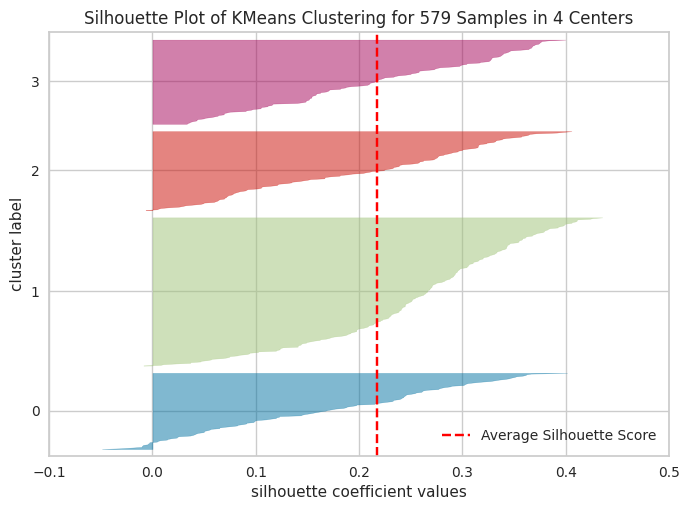

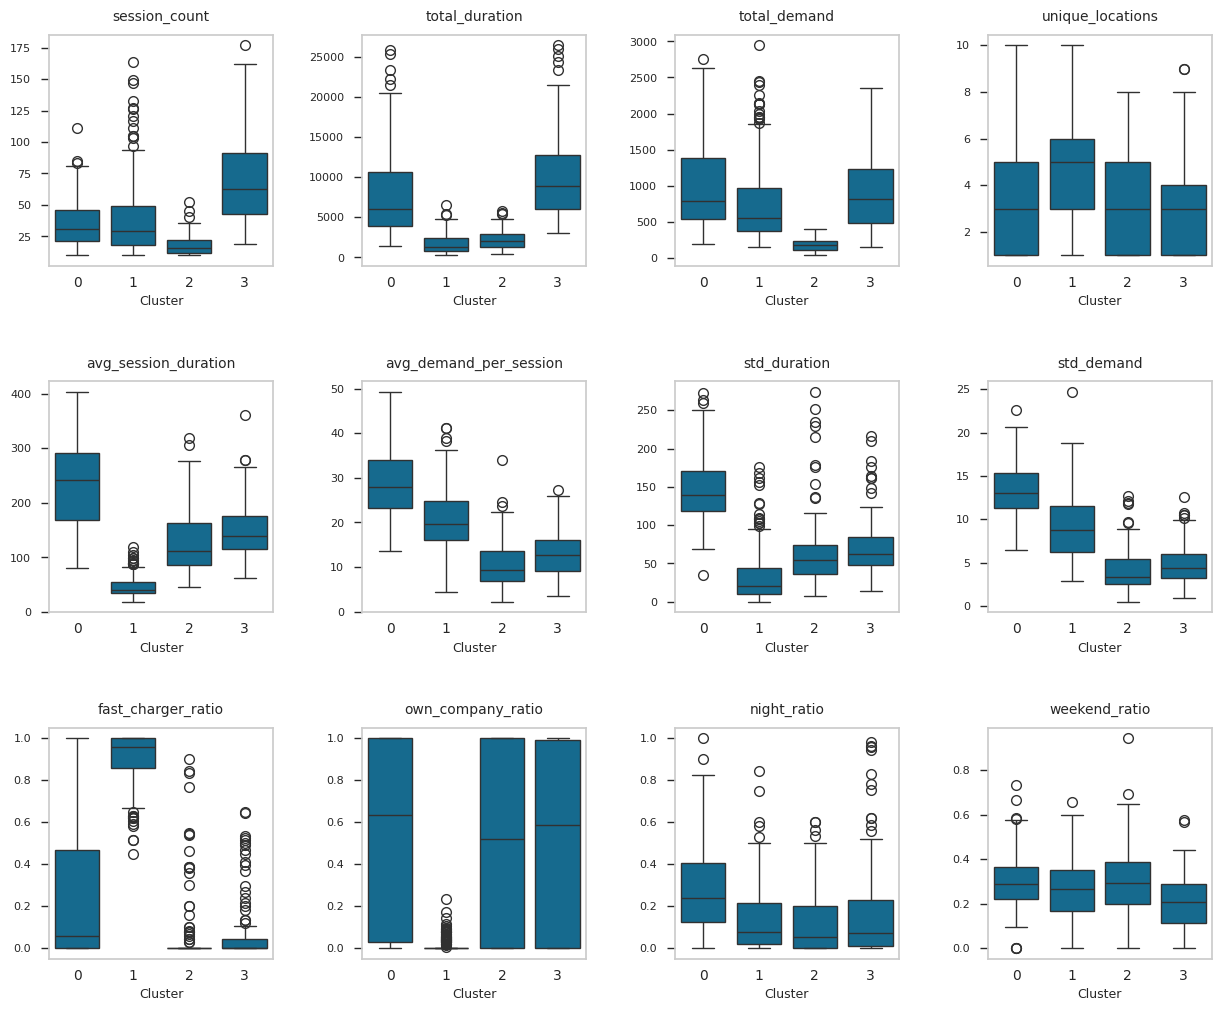

In [54]:
kmeans_data_cluster_results_2 = perform_kmeans_clustering(data, k=4, n_init=10, max_iter=100, tol=0.0001)

Silhouette plot analysis summary

* Average score: ~0.22, indicating very weak clustering structure

* All clusters: Show mostly positive coefficients (0 to 0.45), suggesting generally appropriate assignments

* Cluster sizes: Appear relatively balanced with cluster 1 possibly having more spread

* Boundary samples: All clusters have samples with low scores (0-0.1), suggesting some overlap

* No misassignments: Fewer negative values in cluster 0 suggests minimal incorrect cluster assignments

* Overall quality: Acceptable but still quite weak

In [55]:
kmeans_data_cluster_results_2

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        0  
3             0.235294        0  
6             0.226415        0  
7             0.275362        3  
8             0.270492        3  
...                ...      ...  
2356          0.205128        3  
2388          0.500000        1  
2393          0.500000        2  
2421          0.105263        3  
2464          0.300000        2  

[579 rows x 13 columns]

### Clustering Analysis of PCA transformed data

#### Find optimal k

* Same as 'data', the hyperparameter tuning in the draft shows minimal score variation when adjusting n_init, max_iter, and tol. 
* Therefore, we can confidently select the same parameter combination as outlined in the draft version.

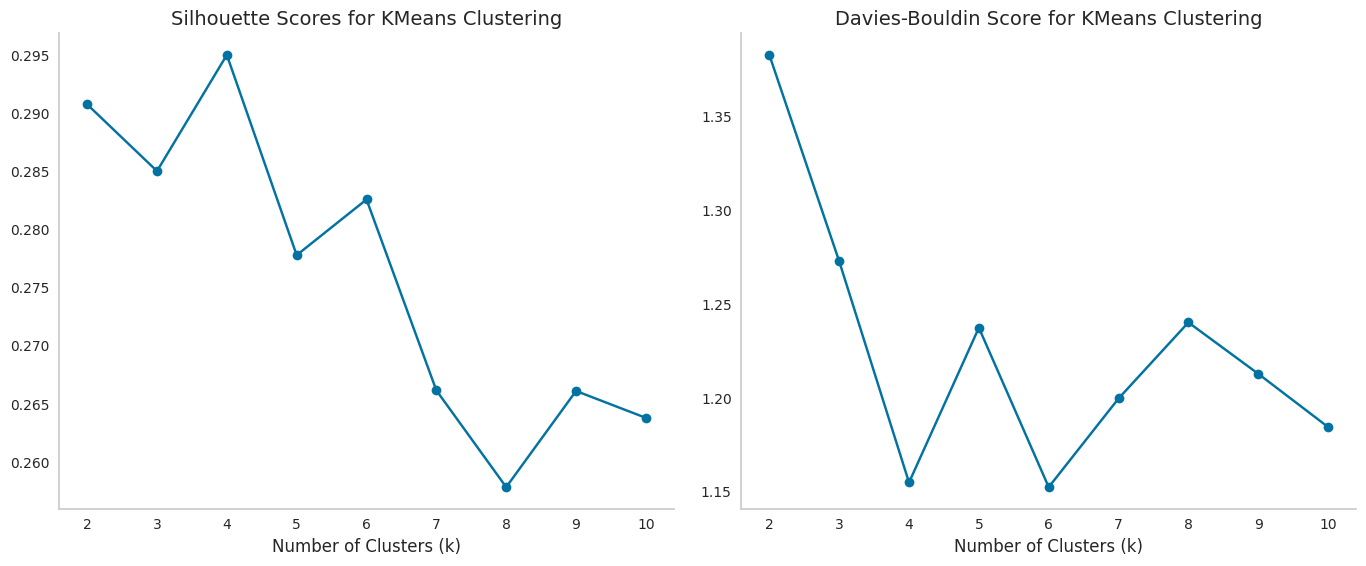

In [56]:
plot_kmeans_metrics(data_pca, n_init=10, max_iter=100, tol=0.001)

* We can see that the result shows a slight improvement when using data_pca but the silhouette scores are still quite slow and davies-bouldin scores are still quite high, meaning the clusters still have weak structure.

* We can choose k = 4 and 6 to inspect the structure of the clusters.

#### Result 1 - data_pca

Cluster
2    229
3    128
1    121
0    101
Name: count, dtype: int64


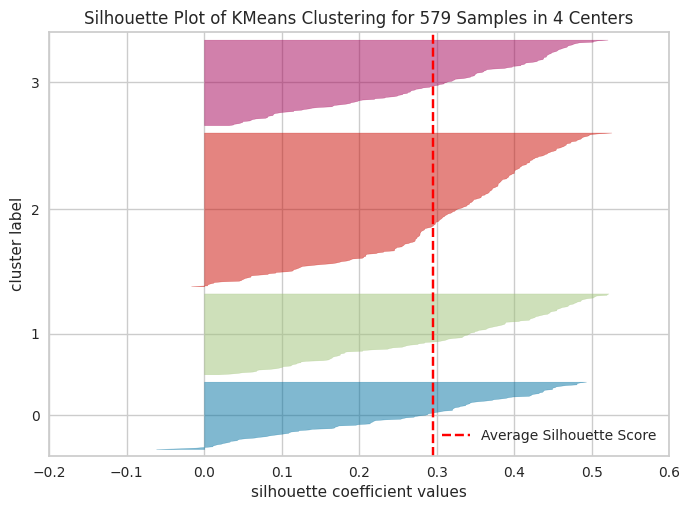

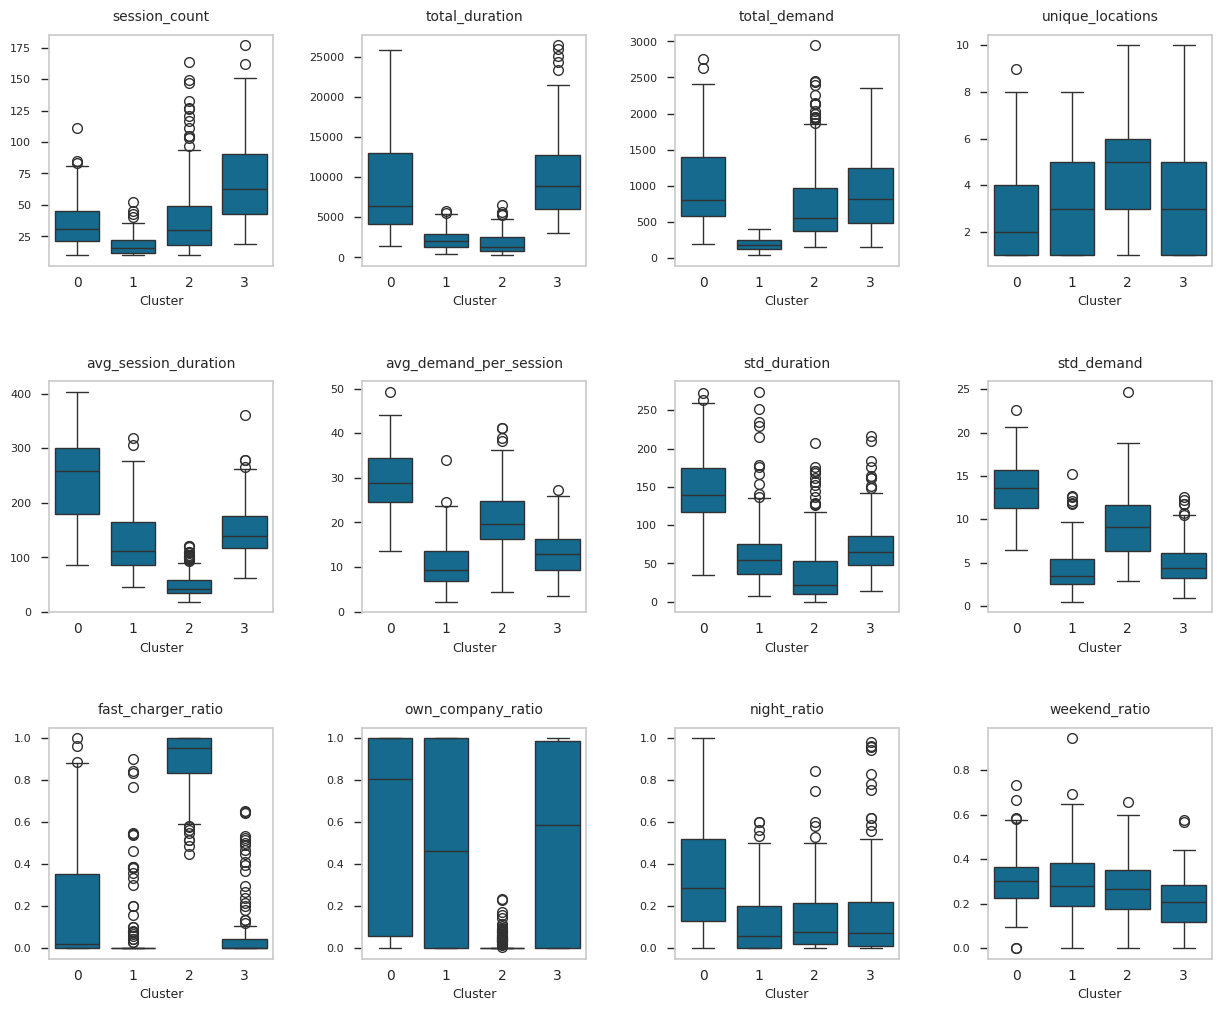

In [57]:
kmeans_data_pca_cluster_results_1 = perform_kmeans_clustering(data_pca, k=4, n_init=10, max_iter=100, tol=0.0001)

Silhouette plot analysis summary

* Average score: ~0.3 (red dashed line), indicating better clustering quality

* Improved separation: Most samples have silhouette scores above the average line, showing better cluster definition

* Higher range: Silhouette values extend to ~0.55, significantly better than previous models

* Consistent structure: All clusters maintain positive values with minimal samples near zero

* Balanced quality: All four clusters show good internal consistency

* Overall assessment: Superior clustering compared to previous models, with stronger separation and more cohesive groupings

In [58]:
kmeans_data_pca_cluster_results_1

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        0  
3             0.235294        0  
6             0.226415        0  
7             0.275362        3  
8             0.270492        3  
...                ...      ...  
2356          0.205128        3  
2388          0.500000        2  
2393          0.500000        1  
2421          0.105263        3  
2464          0.300000        1  

[579 rows x 13 columns]

#### Result 2 - data_pca

Cluster
5    122
0    111
3    106
1     88
4     83
2     69
Name: count, dtype: int64


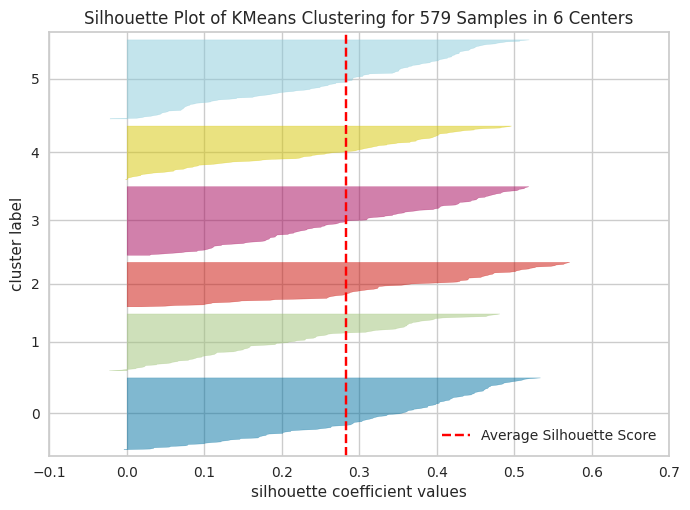

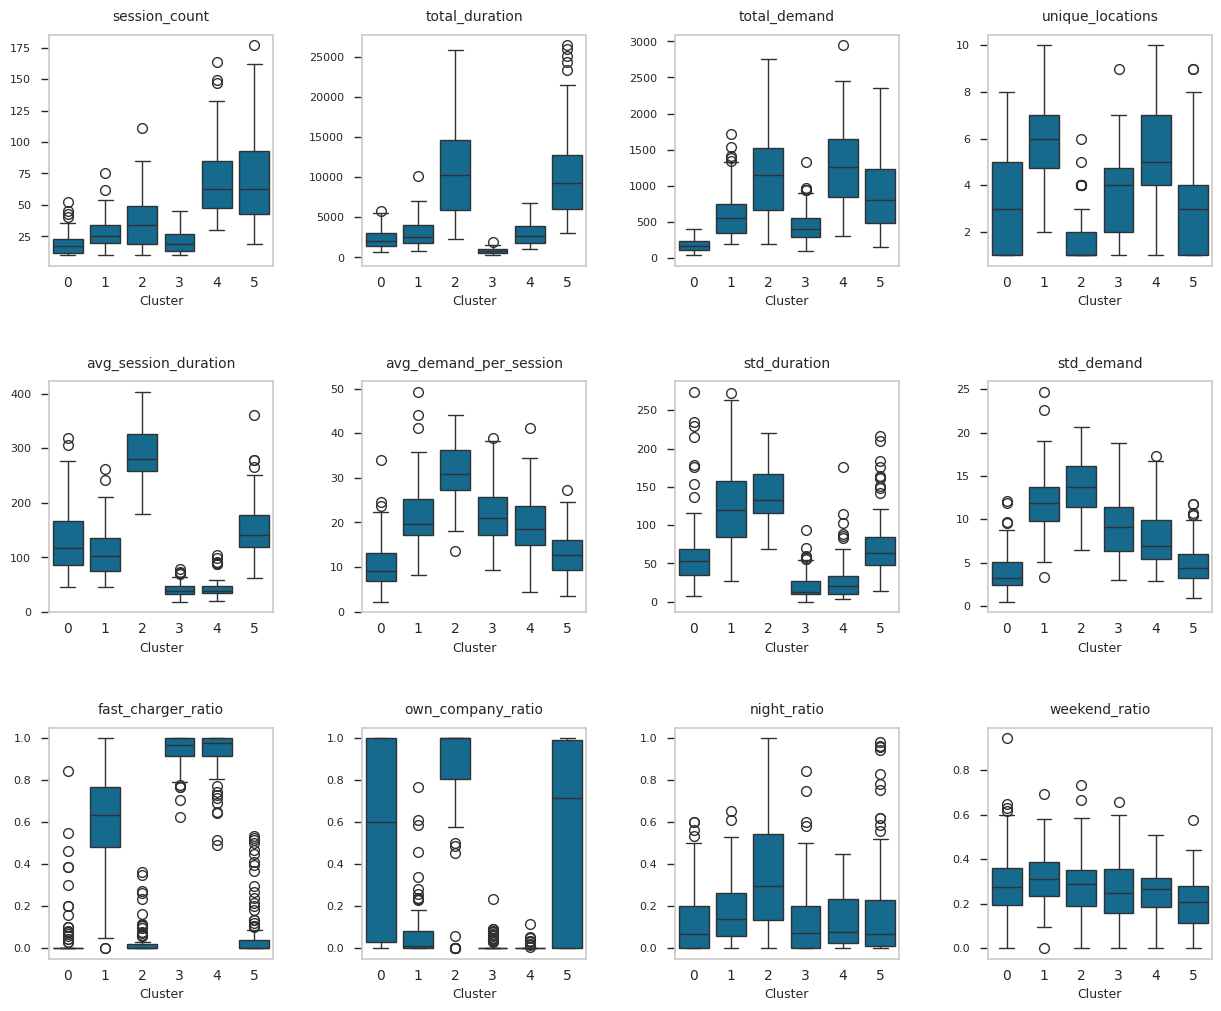

In [59]:
kmeans_data_pca_cluster_results_2 = perform_kmeans_clustering(data_pca, k=6, n_init=10, max_iter=100, tol=0.0001)

Silhouette plot analysis summary

* Average Score: ~0.25-0.3 (red dashed line), indicating weak clustering quality

* Increased fragmentation: Using 6 centers has divided the data into more clusters, potentially over-segmenting

* Wide range: Silhouette values span from near 0 to ~0.6, showing inconsistent cluster quality

* Boundary samples: Several clusters have many samples with values between 0-0.2, suggesting overlap

* Size imbalance: Clusters appear to have varying sizes, with some potentially too small

* Comparison: The overall structure appears less balanced than the 4-center model

In [60]:
kmeans_data_pca_cluster_results_2

session_count  total_duration  total_demand  unique_locations  \
user_id                                                                  
2                   39            7020        806.92                 1   
3                   34            5862        797.31                 7   
6                   53           15367       2009.16                 4   
7                   69           17349       1426.34                 3   
8                  122           23317       1484.12                 3   
...                ...             ...           ...               ...   
2356                39            6295        304.79                 2   
2388                12             563        218.83                 4   
2393                10            1509         62.58                 1   
2421                19            3890        466.68                 2   
2464                10            1045         45.59                 1   

         avg_session_duration  avg_demand_per_session  std_duration  \
user_id                                                               
2                  180.000000               20.690256     97.696361   
3                  172.411765               23.450294    133.319647   
6                  289.943396               37.908679    190.851373   
7                  251.434783               20.671594     65.933228   
8                  191.122951               12.164918    120.510181   
...                       ...                     ...           ...   
2356               161.410256                7.815128     47.332373   
2388                46.916667               18.235833     34.739180   
2393               150.900000                6.258000     30.895703   
2421               204.736842               24.562105     81.338007   
2464               104.500000                4.559000     30.562322   

         std_demand  fast_charger_ratio  own_company_ratio  night_ratio  \
user_id                                                                   
2         11.282258            0.000000           1.000000     0.051282   
3         10.699674            0.352941           0.588235     0.088235   
6         16.958805            0.264151           0.735849     0.132075   
7          5.247983            0.014493           0.000000     0.144928   
8          3.670116            0.016393           0.000000     0.073770   
...             ...                 ...                ...          ...   
2356       2.055936            0.000000           0.974359     0.435897   
2388       4.779984            0.916667           0.000000     0.250000   
2393       1.363205            0.000000           1.000000     0.500000   
2421       6.418442            0.105263           0.894737     0.105263   
2464       1.684072            0.000000           0.000000     0.200000   

         weekend_ratio  Cluster  
user_id                          
2             0.282051        2  
3             0.235294        1  
6             0.226415        2  
7             0.275362        5  
8             0.270492        5  
...                ...      ...  
2356          0.205128        5  
2388          0.500000        3  
2393          0.500000        0  
2421          0.105263        5  
2464          0.300000        0  

[579 rows x 13 columns]

### Best result choice from data and data_pca for comparision

* For 'data_pca', both scores strongly indicate that k = 4 is the optimal choice. 
* Additionally, when analyzing the cluster results, k = 4 produces more balanced clusters with distinct boundaries in their characteristics. => **kmeans_data_pca_cluster_results_1**

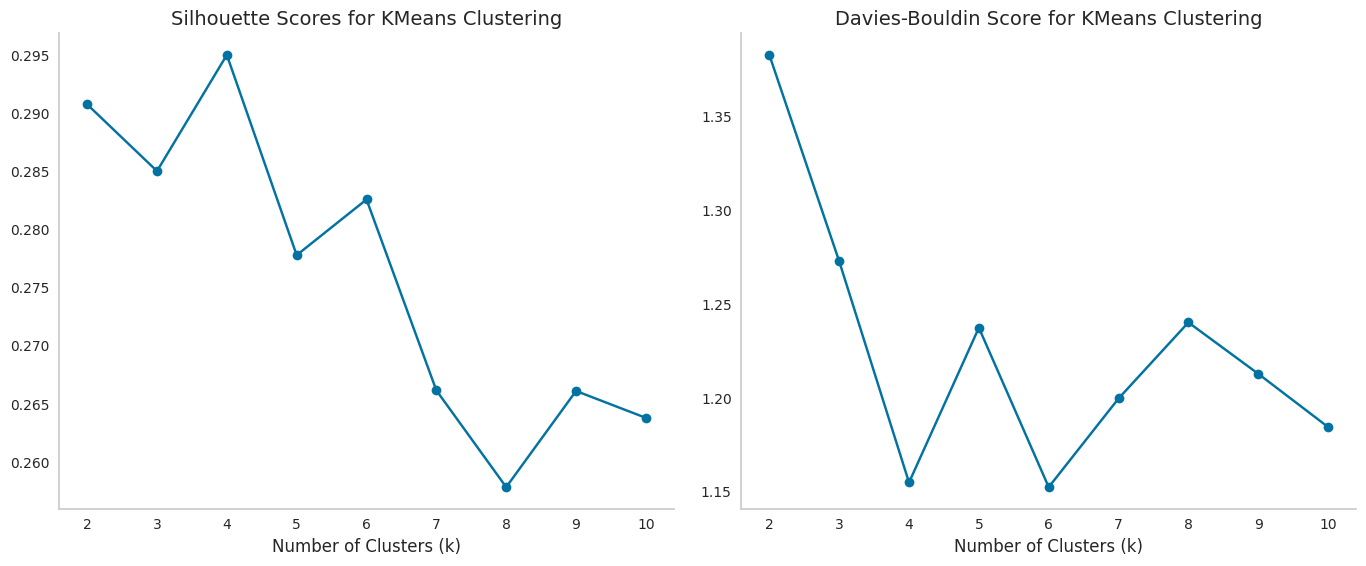

In [61]:
plot_kmeans_metrics(data_pca, n_init=10, max_iter=100, tol=0.001)

* For 'data', the Silhouette score suggests that k = 2 is the best option, while the Davies-Bouldin score recommends k = 6. 
* Choosing either of these values might not be justifiable, as it would adversely affect the other score. 
* Therefore, selecting k = 4 offers a good compromise between the two metrics. 
* When analyzing the cluster results, k = 4 also generates more balanced clusters with distinct boundaries in their characteristics. => **kmeans_data_cluster_results_2**
</div>

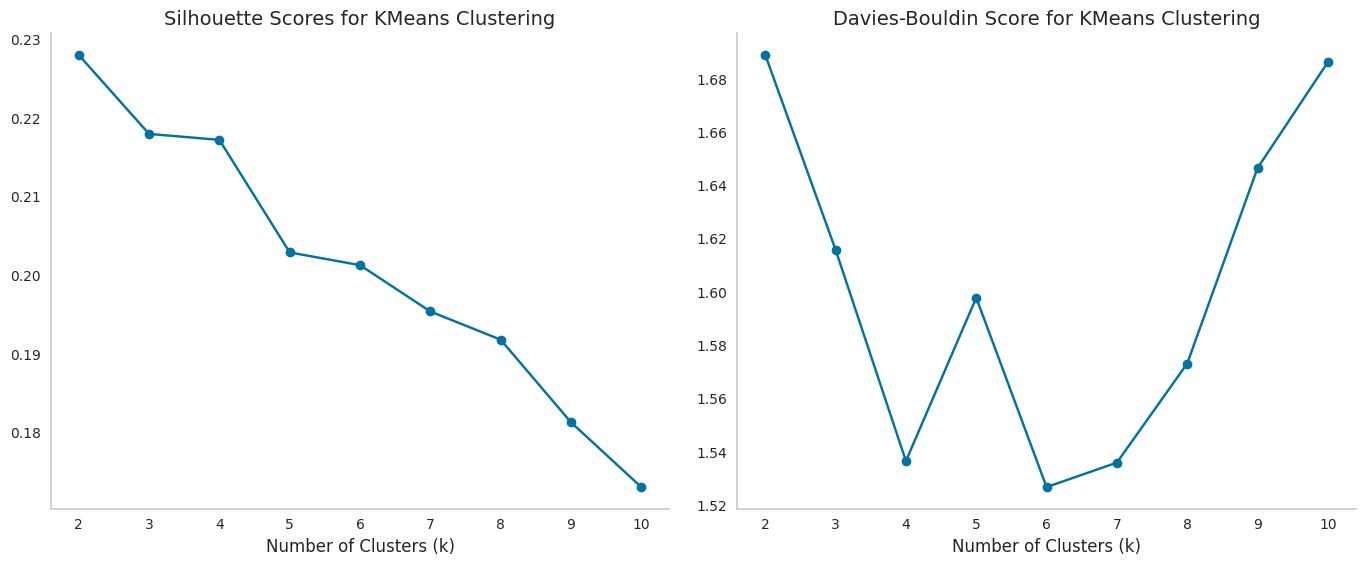

In [62]:
plot_kmeans_metrics(data, n_init=10, max_iter=100, tol=0.001)

# Task 7 -- Clustering Comparison

<div class="alert alert-block alert-warning"> 
<b>Comparison</b>: 
Compare both clustering from the previous task as described in Task 7.

(Commented code + bullet points, add cells below)
</div>

Both original and PCA-transformed datasets distribute instances quite evenly among the clusters.

| Cluster   | Result - data| Result - data_pca |
|-----------|--------------|-------------------|
| 0         | 114          | 101               |
| 1         | 221          | 229               |
| 2         | 118          | 121               |
| 3         | 126          | 128               |

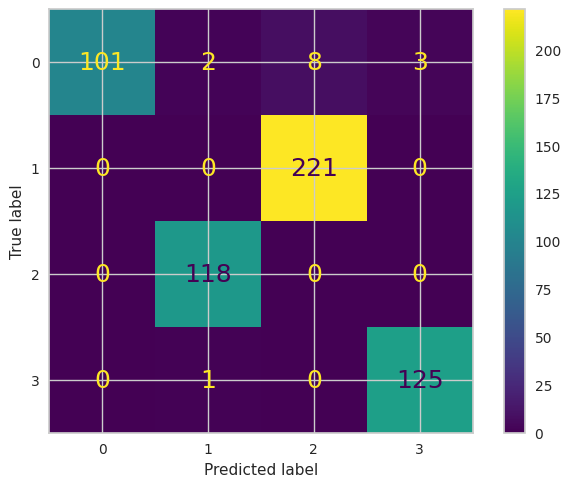

In [63]:
# Create confusion matrix
labels_data = kmeans_data_cluster_results_2['Cluster']
labels_data_pca = kmeans_data_pca_cluster_results_1['Cluster']
cm = confusion_matrix(labels_data, labels_data_pca)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

* The analysis reveals that clustering results from both the original dataset and the PCA-transformed data are almost identical, with clusters 1 and 2 simply swapped.

* PCA proved successful due to:

    * Efficient dimension reduction: PCA effectively reduced dimensions while preserving key patterns, as shown by the high correspondence between clusters, suggesting minimal information loss.

    * Robust data structure validation: Consistent clustering results affirm the stability of the data structure, indicating that the underlying patterns persist beyond full dimensionality.

    * They achieve a better Silhouette score (~0.3 compared to ~0.22) and a lower Davies-Bouldin score (~1.15 compared to ~1.54). 

* Although the final dataset is relatively small with 579 instances so the benefits of computational efficiency and memory savings aren't fully realized yet, PCA demonstrates potential for enhanced scalability. 
* This suggests it would perform well with larger datasets or in higher-dimensional contexts.



# Task 8 -- Conclusions and Future Work

<div class="alert alert-block alert-warning"> 
<b>Subtasks</b>: 
For each subtask, create a fitting headline and add additional code and markdown cells below to conduct the respective task.
    
(Commented code + bullet points, add cells below)
</div>


### 8.1. Selection of Final Clustering

* After thorough comparative analysis between the original dataset and PCA-transformed data clustering results, the PCA-based clustering emerges as clearly superior for several compelling reasons:

    * **Superior quality metrics**: The PCA-based clustering demonstrates significantly better performance with a silhouette score of ~0.3 compared to ~0.22 for the original data, and a Davies-Bouldin score of ~1.15 versus ~1.54. These metrics indicate more cohesive and better-separated clusters.

    * **Dimensional efficiency**: The PCA transformation successfully reduced dimensionality while preserving the essential structure of the data, eliminating noise and redundancy that could obscure natural groupings in the original 12-dimensional space.

    * **Interpretability balance**: While both approaches yield interpretable clusters, the PCA-based segmentation provides cleaner separation between customer groups, making it more actionable for business applications without sacrificing meaningful differentiation.

    * **Computational advantage**: The reduced dimensionality of the PCA approach offers scalability benefits that would become increasingly important as the dataset grows with additional customers and transactions.

### 8.2. Features of the Clusters

Cluster
2    229
3    128
1    121
0    101
Name: count, dtype: int64


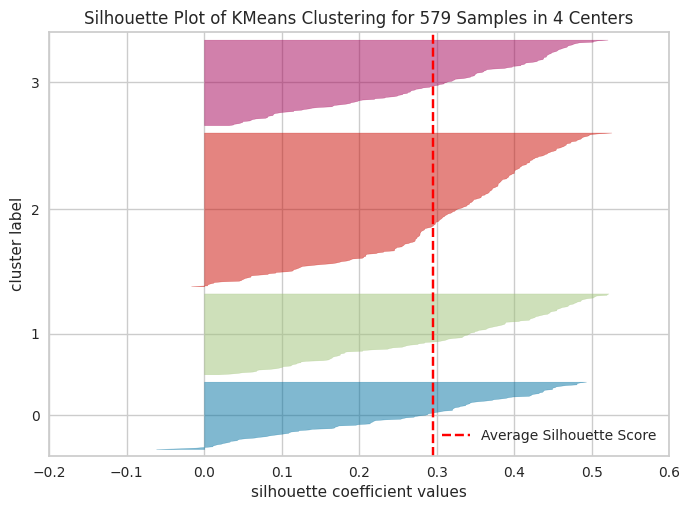

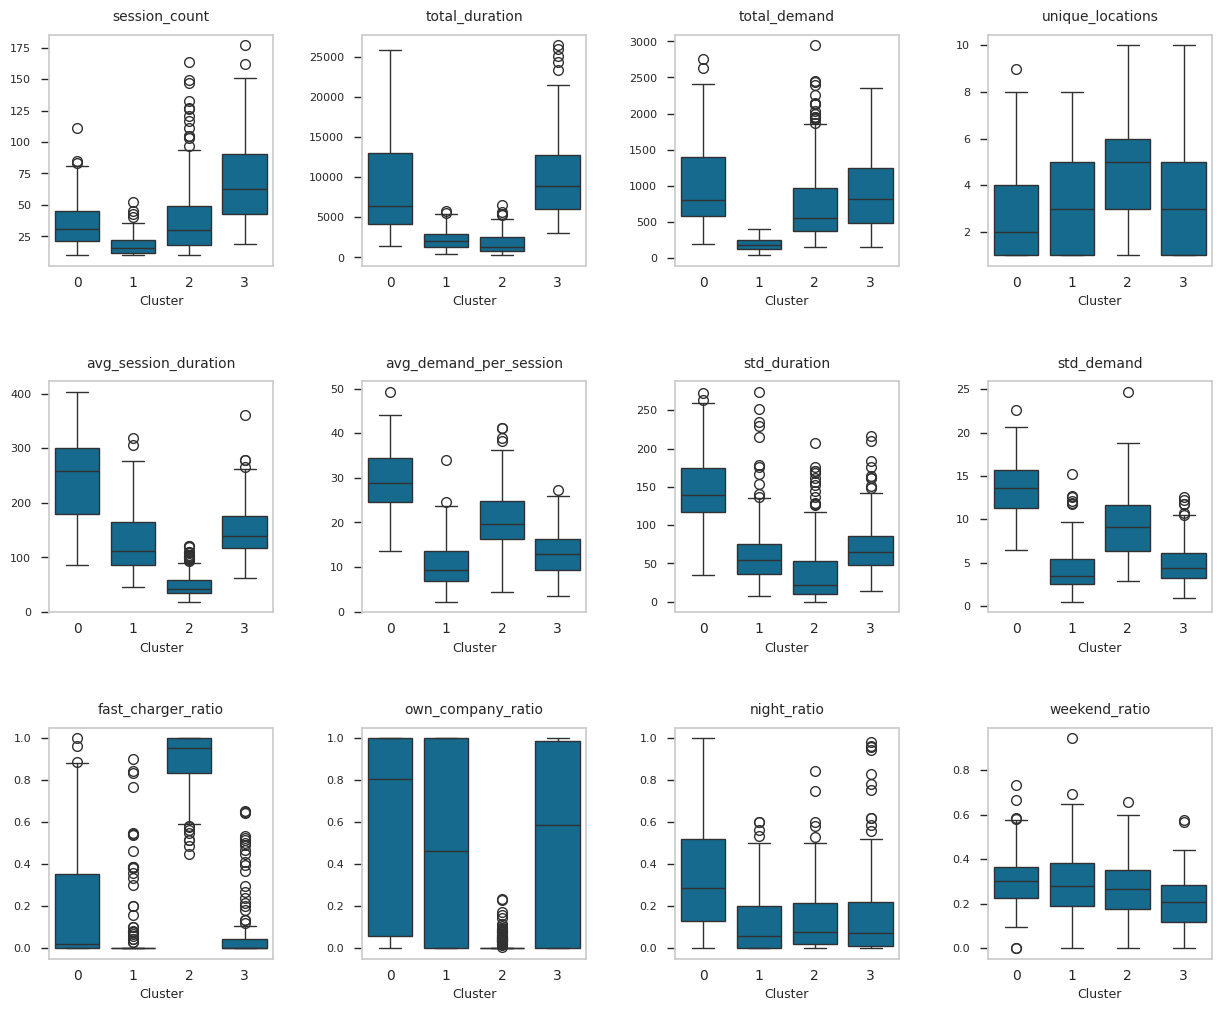

In [64]:
kmeans_data_pca_cluster_results_1 = perform_kmeans_clustering(data_pca, k=4, n_init=10, max_iter=100, tol=0.0001)

* Our final clustering solution reveals four distinct customer segments with well-defined characteristics that offer actionable insights for business strategy:

| **Cluster Number** | **Cluster Name**               | **Core Behavior**                                                                                                    | **Loyalty Profile**                                                        | **Temporal Patterns**                            | **Business Implications**                                                                                |
|--------------------|--------------------------------|----------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------|-------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| **0**              | **Long-Session Loyalists**     | Engage in extended charging sessions with high average duration and demand per session                                | Strong company preference                                                 | Highest nighttime usage ratio                    | Ideal candidates for premium subscription models and overnight charging packages Targets for reservation systems and loyalty rewards |
| **1**              | **Low-Usage Experimenters**    | Lowest engagement across all metrics with minimal session count and total demand                                      | Moderate company loyalty                                                  | Predominantly daytime users                      | Growth opportunity through activation strategies educational content and introductory incentives                                    |
| **2**              | **Fast-Charging Nomads**       | Preference for fast charging and highest location diversity                                                           | Lowest company loyalty                                                    | High mobility with diverse locations preference  | Require competitive fast-charging rates and location-based promotions for engagement                                                |
| **3**              | **High-Volume Regulars**       | Highest engagement with maximum session count and total duration                                                      | High company loyalty                                                      | Consistent weekday usage pattern possibly workplace-related | Represent the highest lifetime value suited for workplace partnerships and weekday subscription models                             |

### 8.3. Summary of Results

* The customer segmentation analysis has successfully fulfilled the project objectives while yielding several valuable insights:

    * **Objective achievement**: We have effectively segmented EV charging customers into four distinct, interpretable groups that capture meaningful differences in charging behavior, usage patterns, and preferences.

    * **Actionable insights**: The segmentation reveals clear behavioral patterns that directly inform business strategy. From the loyalty-focused "Long-Session Loyalists" to the convenience-seeking "Fast-Charging Nomads," each segment presents unique opportunities for targeted engagement.

    * **Validated approach**: The consistency between original and PCA-based clustering results validates the robustness of the identified segments. The superior metrics of the PCA approach confirm that we have captured fundamental patterns rather than noise.

    * **Business relevance**: The segmentation aligns with practical business considerations, addressing key dimensions of customer behavior including frequency, duration, location diversity, charging speed preference, and temporal patterns. These dimensions directly inform pricing strategies, infrastructure planning, and marketing initiatives.

    * **Implementation readiness**: Each customer has been definitively assigned to a segment, enabling immediate operationalization of the results. The clear characterization of each segment provides actionable guidance for marketing, product development, and customer service teams.

### 8.4. Generated Value and Impact on Organization

* The customer segmentation analysis provides significant value to your organization in several ways:

    * **Enhanced marketing efficiency**: The four distinct customer segments identified allow for highly targeted marketing campaigns tailored to each group's specific charging behaviors and preferences. For example, "Fast-Charging Nomads" could be targeted with promotions emphasizing the company's network breadth, while "Long-Session Loyalists" might respond better to nighttime charging discounts.

    * **Strategic infrastructure planning**: Understanding the charging patterns of different customer segments enables more efficient resource allocation. For instance, locations frequented by "High-Volume Regulars" might benefit from additional chargers, while areas popular with "Fast-Charging Nomads" would prioritize high-speed charging options.

    * **Customer retention strategies**: Each segment presents different churn risks and opportunities. "High-Volume Regulars" represent high-value customers worth investing in retention programs, while "Low-Usage Experimenters" might benefit from educational content to increase engagement.

    * **Product development guidance**: The segmentation provides clear direction for developing new services or features. The "Long-Session Loyalists" segment might appreciate reservation systems for overnight charging, while "Low-Usage Experimenters" could be enticed with introductory packages.



### 8.5. Limitations and Pitfalls

* Despite the valuable insights gained, several limitations should be acknowledged:

    * **Temporal dynamics**: The analysis represents a static snapshot of customer behavior. Users may migrate between segments over time, particularly as EV adoption matures. The current segmentation doesn't capture these evolving patterns.

    * **Limited contextual data**: The dataset lacks important contextual information such as vehicle types, battery capacities, and demographic details that could enhance segment interpretation. For example, "Low-Usage Experimenters" might include both occasional EV users and those who primarily charge at home.

    * **Geographical constraints**: While location types are captured, specific geographical distribution is missing. Regional variations in charging behavior cannot be adequately analyzed, potentially masking important patterns.

    * **Weak cluster separation**: The relatively low silhouette scores (around 0.3) indicate weak cluster boundaries, suggesting some overlap between customer segments. This could lead to misclassification when implementing targeted strategies.

    * **Feature engineering limitations**: The derived features, while informative, may not capture all relevant aspects of charging behavior. Additional metrics like charging session abandonment rates or peak-hour usage could provide further differentiation.

    * **Data quality issues**: Due to data quality concerns, some instances had to be excluded from the analysis. This could limit the representativeness of the findings and potentially overlook certain customer behaviors.

### 8.6. Ideas for Future Work

* Building on the current analysis, several promising directions for future work emerge:

    * **Longitudinal analysis**: Implement a time-series approach to track customer migration between segments over time. This would help identify trigger events that cause behavioral shifts and enable predictive modeling of segment transitions.

    * **Enhanced data collection**: Enrich the dataset with additional variables such as vehicle type, battery capacity, user demographics, and weather conditions during charging sessions. This would provide more nuanced segmentation and deeper insights.

    * **Predictive modeling**: Develop predictive models for each segment to forecast future charging demand, optimal charger placement, and potential revenue streams. This could support more proactive business planning.

    * **A/B testing framework**: Create an experimental framework to test different marketing messages, pricing strategies, and service offerings across segments. This would validate the practical utility of the segmentation and refine targeting approaches.

    * **Integration with CRM Systems**: Implement real-time segment classification within customer relationship management systems to enable dynamic personalization of customer interactions and offers.

    * **Competitive analysis**: Compare segment distributions with industry benchmarks or competitor data to identify underserved segments or market opportunities.

    * **Analysis of unsubscribed users**: Unlike subscribed users, unsubscribed users were excluded from the raw data due to the inability to aggregate based on user ID. It is also interesting to analyze their charging behavior, as they may reveal patterns and insights independent of user identity. This could uncover potential areas for engagement or untapped charging behavior patterns.

### 8.7. Critique of Methodology

* The methodology employed in this analysis has several strengths but also some areas for improvement:

    * Strengths:
        * The preprocessing steps were thorough, particularly in handling outliers and transforming skewed features.
        * The comparison between original and PCA-transformed data provided validation of the underlying structure.
        * The feature engineering effectively captured various dimensions of charging behavior.

    * Areas for Improvement:
        * **Algorithm selection**: While K-means provided interpretable results, density-based algorithms like OPTICS might have better captured the natural cluster structure, especially given the weak separation indicated by silhouette scores.

        * **Feature selection**: A more systematic approach to feature selection, such as recursive feature elimination, might have identified a more optimal feature subset.

        * **Alternative distance metrics**: Experimenting with distance metrics beyond Euclidean distance (e.g., Manhattan distance) could potentially improve clustering for this specific dataset.

### 8.8. Reflection on Original Pitch

* Critically reflecting on our original pitch for customer segmentation, several insights emerge about the realism of our goals and potential improvements:

    * **Objective realism** : The primary objective to "conduct customer segmentation to identify and analyze different EV charging customer groups" was realistic and achievable. Our expectation to develop "clusters with interpretable characteristics" was appropriately scoped and successfully met. The four distinct segments we identified provide clear, actionable insights despite some overlap between groups.
    * **Data limitations**: The pitch did not adequately acknowledge potential limitations in the available data. While we successfully worked with transaction data, the absence of demographic information, vehicle specifications, and user preferences constrained the depth of our segmentation.
